# Trabajo Pr√°ctico 2

## 1. Implemente un perceptr√≥n simple que aprenda la funci√≥n l√≥gica AND y la funci√≥n l√≥gica OR, de 2 y de 4 entradas. Muestre la evoluci√≥n del error durante el entrenamiento. Para el caso de 2 dimensiones, grafique la recta discriminadora y todos los vectores de entrada de la red.

## Entrenamiento de un perceptr√≥n con historial de pesos por √©poca

El siguiente c√≥digo implementa un **perceptr√≥n simple** con *bias* absorbido, dise√±ado para tareas l√≥gicas como **AND / OR**, y permite registrar la evoluci√≥n de los **pesos** y del **error cuadr√°tico medio (ECM)** a lo largo de las √©pocas de entrenamiento.

---

### Descripci√≥n general

El perceptr√≥n es un clasificador lineal binario que actualiza sus pesos cada vez que comete un error.  
En este caso, se usa un vector aumentado (incluyendo el *bias*) para simplificar la regla de actualizaci√≥n.

El flujo de entrenamiento es el siguiente:

1. Se inicializan los pesos de forma aleatoria seg√∫n una distribuci√≥n normal **N(0, 0.01)**.  
2. En cada √©poca, se recorren todas las muestras (en orden fijo o aleatorio).  
3. Si una muestra est√° mal clasificada, se ajustan los pesos.  
4. Al final de cada √©poca, se guarda el vector de pesos y el ECM.  
5. Si no hay errores en una √©poca, el entrenamiento se detiene (convergencia).

---

### Funciones principales

- **step(h)**  
  Funci√≥n de activaci√≥n por signo. Devuelve +1 si la entrada es mayor o igual a 0, y -1 en caso contrario.

- **augment_with_bias(X)**  
  Agrega una columna de unos a la matriz de entradas `X`, de modo que el √∫ltimo peso del vector `w` act√∫e como *bias*.  
  Esto permite tratar el *bias* como un peso m√°s.

- **forward_aug(X_aug, w_aug)**  
  Calcula la salida del perceptr√≥n (ya con la entrada aumentada) aplicando el producto punto entre las entradas y los pesos, seguido de la funci√≥n de activaci√≥n `step`.

- **predict(X, w_aug)**  
  Facilita la predicci√≥n sobre datos sin aumentar. Internamente llama a `augment_with_bias` y `forward_aug`.

- **mse(y_true, y_pred)**  
  Calcula el **Error Cuadr√°tico Medio (ECM)** entre las etiquetas verdaderas y las predicciones.  
  Este valor se usa como m√©trica de desempe√±o durante el entrenamiento.

---

### Funci√≥n de entrenamiento

**train_perceptron_aug_with_history(X, y, eta, max_epochs, shuffle, random_state)**  

Entrena el perceptr√≥n de manera **en l√≠nea** (muestra por muestra) y guarda el historial de pesos y ECM.

**Par√°metros:**
- **X**: matriz de entrenamiento, donde cada fila es un patr√≥n de entrada.  
- **y**: vector de etiquetas en {+1, -1}.  
- **eta**: tasa de aprendizaje (valor peque√±o, como 0.1).  
- **max_epochs**: n√∫mero m√°ximo de √©pocas.  
- **shuffle**: si es True, mezcla las muestras en cada √©poca.  
- **random_state**: semilla aleatoria opcional para reproducibilidad.

**Retorna:**
- **w_hist**: matriz con los pesos finales de cada √©poca (incluyendo el bias).  
- **ecms**: lista con el ECM calculado en cada √©poca.

---

#### Criterio de parada

El entrenamiento se detiene de forma anticipada (**early stopping**) si en una √©poca no hay errores de clasificaci√≥n, lo que indica que el conjunto es linealmente separable.

---




In [2]:
import numpy as np
import matplotlib.pyplot as plt

def step(h: np.ndarray) -> np.ndarray:
    """Signo: +1 si h>=0, -1 si h<0."""
    return np.where(h >= 0, 1, -1)

def augment_with_bias(X: np.ndarray) -> np.ndarray:
    """Agrega una columna de 1s: X -> [X | 1]. El √∫ltimo peso es el bias."""
    X = np.asarray(X, dtype=float)
    ones = np.ones((X.shape[0], 1), dtype=float)
    return np.hstack([X, ones])

def forward_aug(X_aug: np.ndarray, w_aug: np.ndarray) -> np.ndarray:
    """Salida del perceptr√≥n con X """
    return step(X_aug @ w_aug)

def predict(X: np.ndarray, w_aug: np.ndarray) -> np.ndarray:
    """Predice a partir de X (no aumentada)."""
    return forward_aug(augment_with_bias(X), w_aug)

def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """ECM sobre etiquetas en {+1,-1}."""
    y_true = np.asarray(y_true)
    return float(np.mean((y_true - y_pred) ** 2))

# -------------------------
# Entrenamiento con HISTORIAL por √âPOCA
# -------------------------
def train_perceptron_aug_with_history(
    X: np.ndarray,
    y: np.ndarray,
    eta: float = 0.1,
    max_epochs: int = 100,
    shuffle: bool = False,
    random_state: int | None = None,
):
    rng = np.random.default_rng(random_state)
    X_aug = augment_with_bias(X)
    y = np.asarray(y, dtype=int)

    w_aug = rng.normal(0, 0.01, size=X_aug.shape[1])

    w_hist = []
    ecms = []

    for _ in range(max_epochs):
        if shuffle:
            idx = rng.permutation(len(X_aug))
            Xe, ye = X_aug[idx], y[idx]
        else:
            Xe, ye = X_aug, y

        mistakes = 0
        for xi, ti in zip(Xe, ye):
            if step(xi @ w_aug) != ti:
                w_aug += eta * ti * xi
                mistakes += 1

        # log de fin de √©poca SIEMPRE
        w_hist.append(w_aug.copy())
        ecms.append(mse(y, forward_aug(X_aug, w_aug)))

        if mistakes == 0:  # early stop si separ√≥ perfecto
            break

    return np.array(w_hist), np.array(ecms)


### Funciones para generar datos, graficar y ejecutar experimentos

**`dataset_gate(gate="AND", dim=2)`**  
Genera el conjunto de datos correspondiente a la compuerta l√≥gica elegida (**AND** u **OR**).  
Para `dim=2`, el dataset es:

- **Entradas:**  
  $X = \{(0,0), (0,1), (1,0), (1,1)\}$

- **Salidas:**  
  - **AND:** $y = \{-1, -1, -1, +1\}$  
  - **OR:** $y = \{-1, +1, +1, +1\}$

Para `dim=4`, genera todas las combinaciones binarias de 4 bits (16 patrones), con salidas an√°logas para **AND** y **OR**.

---

**`plot_boundary_on_ax(ax, w_aug)`**  
Dibuja la **frontera de decisi√≥n** del perceptr√≥n en el eje `ax` a partir del vector de pesos aumentado  
$w_{\text{aug}} = [w_1, w_2, w_b]$, donde $w_b$ es el *bias*.  
La ecuaci√≥n de la recta de decisi√≥n es:

$$
w_1 x_1 + w_2 x_2 + w_b = 0
\quad \Rightarrow \quad
x_2 = -\frac{w_1 x_1 + w_b}{w_2}
$$

Si $w_2 = 0$, la frontera es vertical ($x_1 = -w_b / w_1$).

---

**`annotate_points(ax, X, y)`**  
Dibuja los puntos del conjunto de datos `X` y los colorea seg√∫n su clase.  
Adem√°s, agrega etiquetas de texto con los valores de salida (+1 o ‚àí1).  
Incluye ejes y cuadr√≠cula para facilitar la lectura.

---

**`run_experiment_for_gate(gate, etas, max_epochs, shuffle, random_state)`**  
Ejecuta un experimento completo para una compuerta l√≥gica determinada (**AND** u **OR**) y una lista de tasas de aprendizaje.

Para cada valor de **Œ∑ (eta)** realiza los siguientes pasos:

1. **Entrena** el perceptr√≥n con `train_perceptron_aug_with_history`, obteniendo:  
   - El historial de pesos por √©poca (`w_hist`).  
   - El error cuadr√°tico medio (`ecms`) por √©poca.  

2. **Grafica el ECM vs. √©poca** para visualizar la convergencia del entrenamiento.

3. **Muestra la evoluci√≥n de la frontera de decisi√≥n** en un panel de subgr√°ficos, uno por cada √©poca, para observar c√≥mo el perceptr√≥n ajusta su frontera a lo largo del entrenamiento.

El procedimiento permite comparar distintas tasas de aprendizaje y visualizar c√≥mo influyen en la **velocidad de convergencia** y en la **estabilidad del entrenamiento**.


In [3]:
def dataset_gate(gate: str = "AND", dim: int = 2):
    g = gate.strip().lower()
    if dim == 2:
        X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
        if g == "and":
            y = np.array([-1,-1,-1, 1], dtype=int)
        elif g == "or":
            y = np.array([-1, 1, 1, 1], dtype=int)
        else:
            raise ValueError("gate debe ser 'AND' u 'OR'")
        return X, y
    elif dim == 4:
        X = np.array([[int(b) for b in f"{i:04b}"] for i in range(16)], dtype=float)
        if g == "and":
            y = np.array([-1]*15 + [1], dtype=int)
        elif g == "or":
            y = np.array([-1] + [1]*15, dtype=int)
        else:
            raise ValueError("gate debe ser 'AND' u 'OR'")
        return X, y
    else:
        raise ValueError("dim debe ser 2 o 4")


def plot_boundary_on_ax(ax, w_aug, eps: float = 1e-12):
    """Dibuja la frontera de decisi√≥n en el eje ax dado w_aug."""
    w1, w2, wb = w_aug
    x_vals = np.linspace(-0.2, 1.2, 200)
    if abs(w2) > eps:
        y_vals = -(w1 * x_vals + wb) / w2
        ax.plot(x_vals, y_vals, linewidth=2)
    elif abs(w1) > eps:
        ax.axvline(x=-wb / w1, linewidth=2)


def annotate_points(ax, X, y):
    """Plotea puntos y etiquetas de clase."""
    X_pos = X[y == 1]; X_neg = X[y == -1]
    ax.scatter(X_pos[:,0], X_pos[:,1], label="+1")
    ax.scatter(X_neg[:,0], X_neg[:,1], label="-1")
    for pt, lab in zip(X, y):
        ax.annotate(str(int(lab)), (pt[0]+0.02, pt[1]+0.02), fontsize=9)
    ax.set_xlim(-0.2, 1.2); ax.set_ylim(-0.2, 1.2)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xlabel("$x_1$"); ax.set_ylabel("$x_2$")
    ax.grid(True)

def run_experiment_for_gate(
    gate: str = "AND",
    etas = (0.01, 0.05, 0.1, 0.5, 1.0),
    max_epochs: int = 100,
    shuffle: bool = False,
    random_state: int = 42,
):
    """
    Para la compuerta 'gate' entrena con cada eta, grafica:
      (1) ECM vs. √©poca y (2) evoluci√≥n lateral de la frontera por √©poca.
    Requiere train_perceptron_aug_with_history(X,y,eta,...) definido previamente.
    """
    X, y = dataset_gate(gate)
    for eta in etas:
        w_hist, ecms = train_perceptron_aug_with_history(
            X, y, eta=eta, max_epochs=max_epochs, shuffle=shuffle, random_state=random_state
        )

        xs = np.arange(1, len(ecms)+1)
        plt.figure(figsize=(5,3))
        if len(ecms) == 1:
            plt.scatter(xs, ecms, s=60)
        else:
            plt.plot(xs, ecms, marker='o')
        plt.xlabel("√âpoca"); plt.ylabel("ECM")
        plt.title(f"ECM por √©poca ‚Äì {gate.upper()} (2) ‚Äì Œ∑={eta}")
        plt.grid(True)
        plt.show()

        n_ep = len(w_hist)
        fig, axes = plt.subplots(1, n_ep, figsize=(3*n_ep, 3), sharex=True, sharey=True)
        if n_ep == 1:
            axes = [axes]

        for i, ax in enumerate(axes, start=1):
            annotate_points(ax, X, y)
            plot_boundary_on_ax(ax, w_hist[i-1])
            ax.set_title(f"√©poca {i}")
            if i == 1:
                ax.legend(loc="upper left", frameon=True)

        fig.suptitle(f"{gate.upper()} (2) ‚Äì evoluci√≥n de la frontera ‚Äì Œ∑={eta}", y=1.05, fontsize=12)
        plt.tight_layout()
        plt.show()


Analizamos **exclusivamente la compuerta l√≥gica AND (2 entradas)**: entrenamos un perceptr√≥n, registramos el **ECM por √©poca** y mostramos, **para cada** $\eta$, dos gr√°ficos: (1) **ECM vs. √©poca** y (2) la **evoluci√≥n de la recta discriminadora** *epoch a epoch*. (No se usa OR en este bloque.)


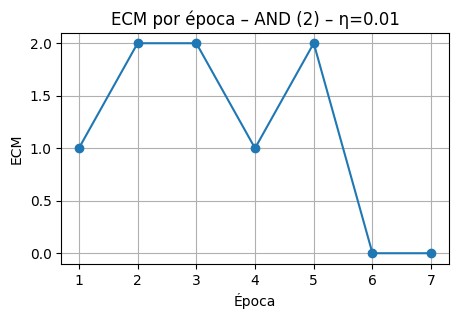

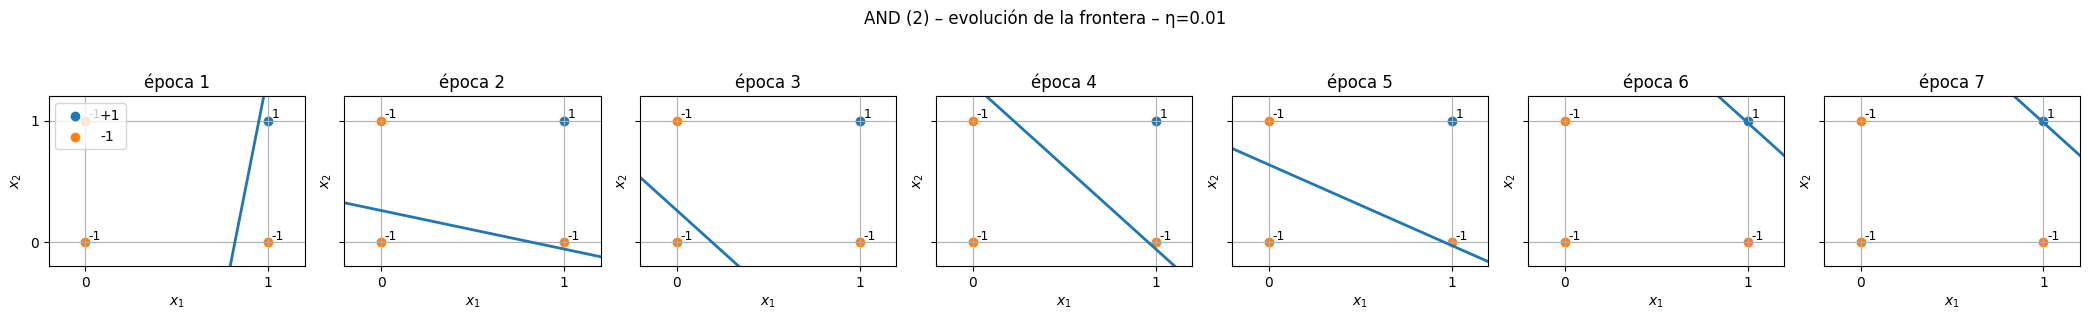

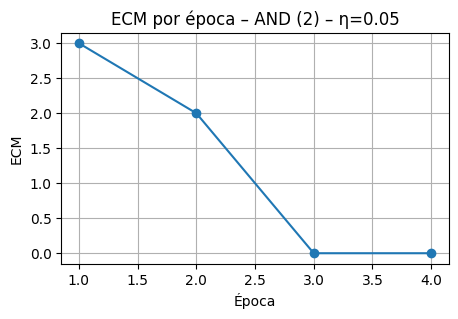

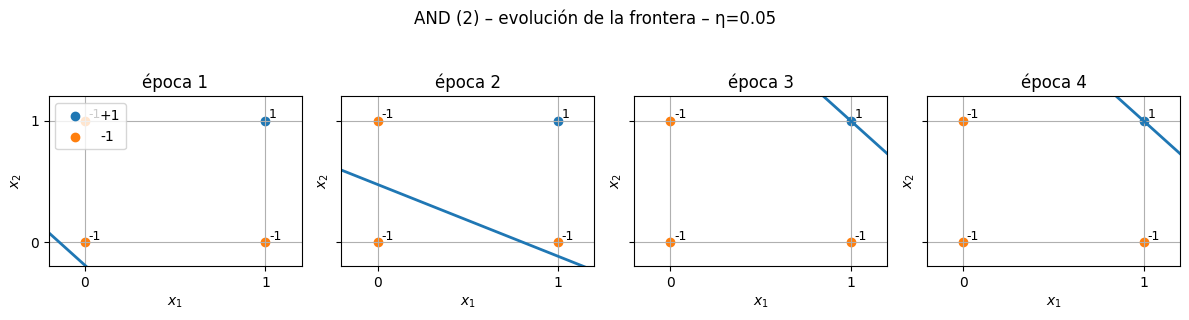

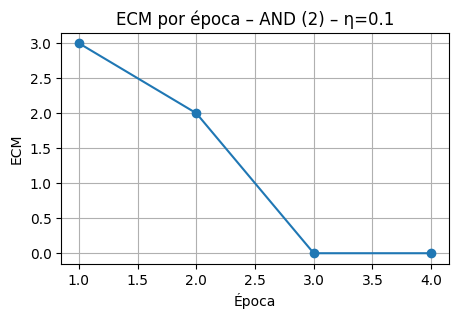

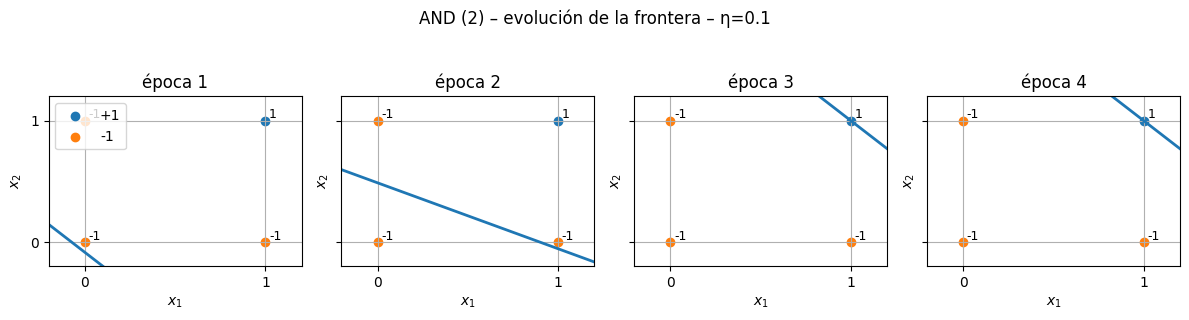

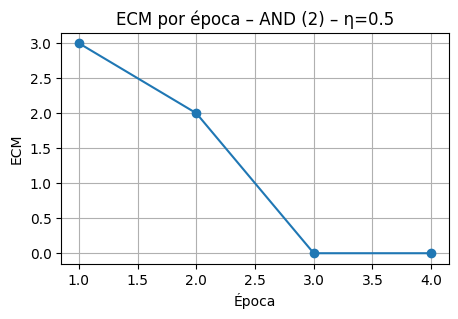

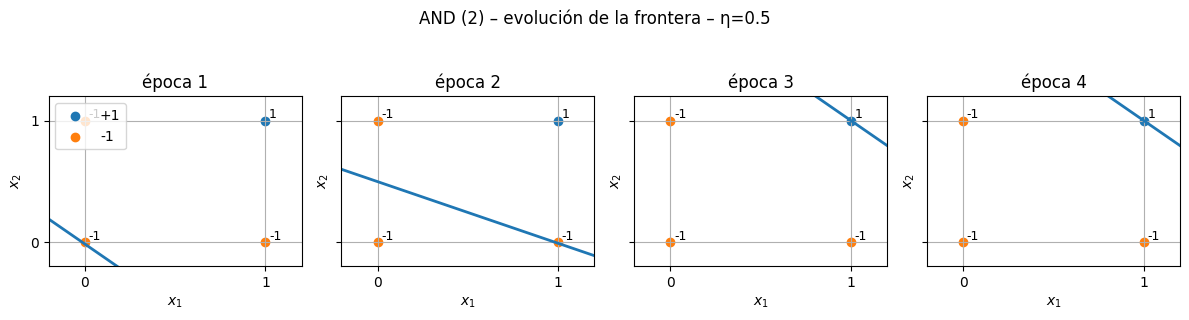

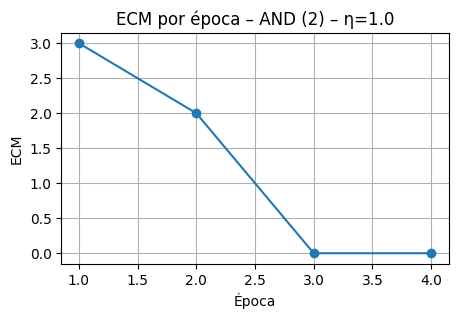

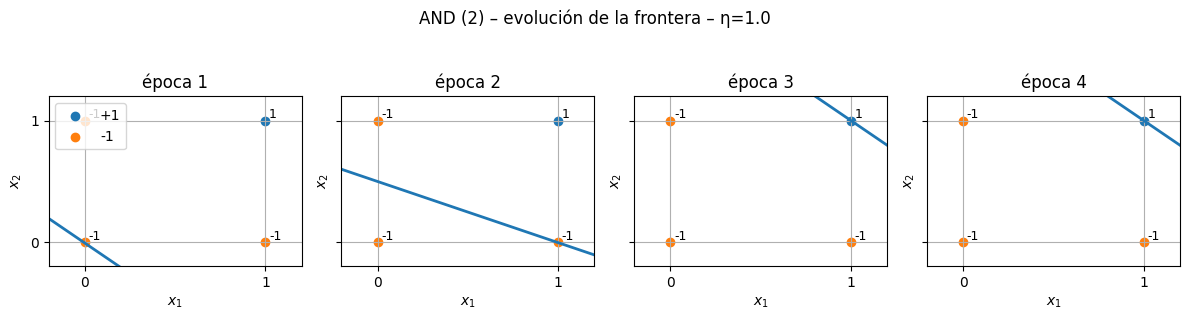

In [4]:
run_experiment_for_gate("AND", etas=[0.01, 0.05, 0.1, 0.5, 1.0], max_epochs=100, shuffle=False, random_state=42)


Analizamos **exclusivamente la compuerta l√≥gica OR (2 entradas)**: entrenamos un perceptr√≥n, registramos el **ECM por √©poca** y mostramos, **para cada** $\eta$, dos gr√°ficos: (1) **ECM vs. √©poca** y (2) la **evoluci√≥n de la recta discriminadora** *epoch a epoch*.  
Datos usados: $X\in\{0,1\}^2$ y $y=\{-1,\; +1,\; +1,\; +1\}$. (No se usa AND en este bloque.)


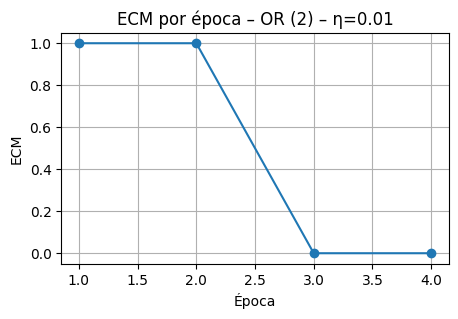

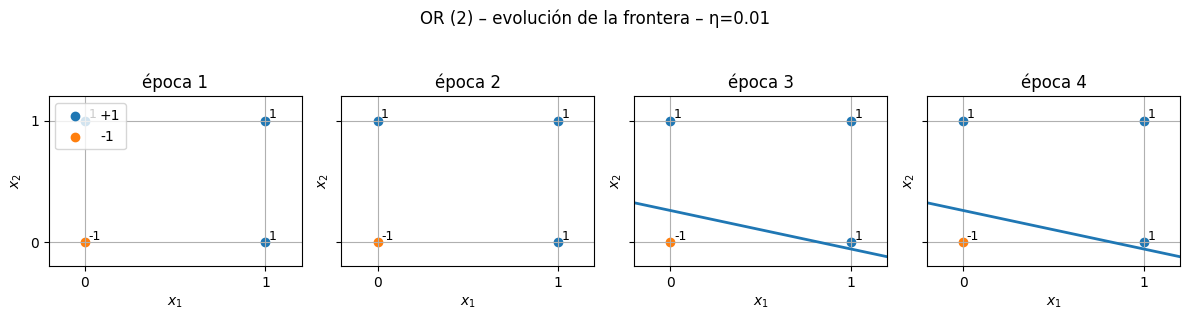

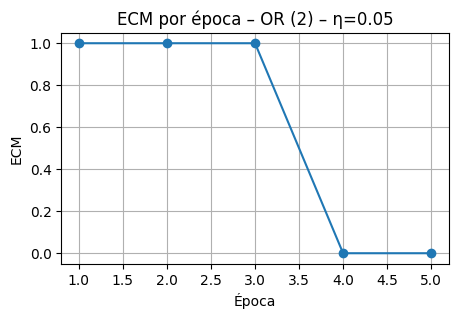

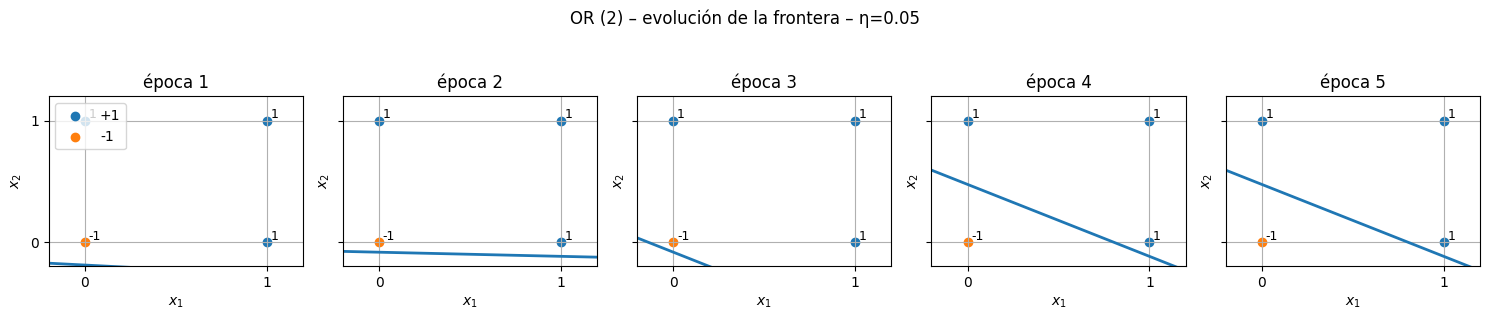

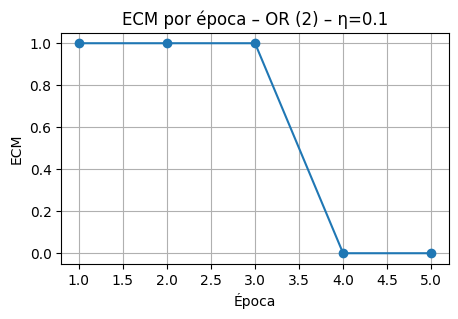

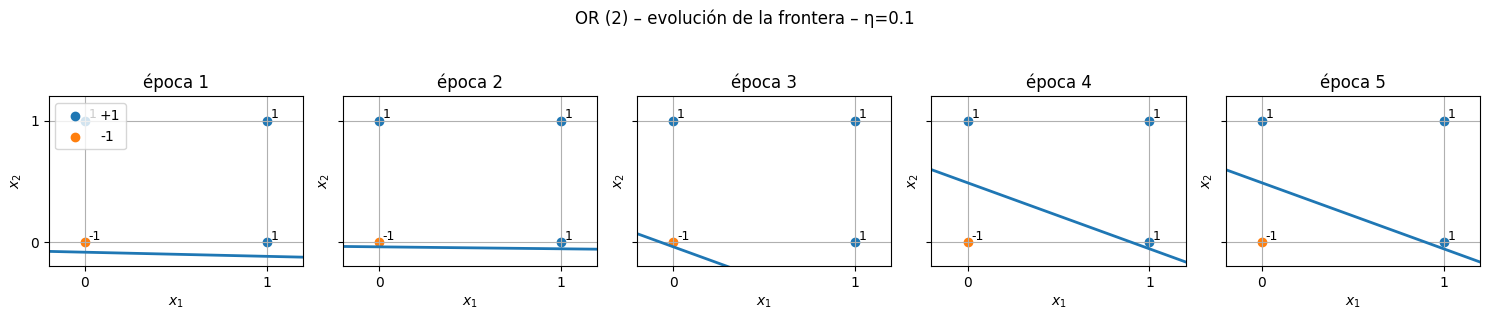

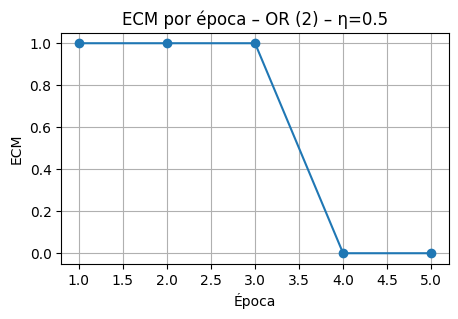

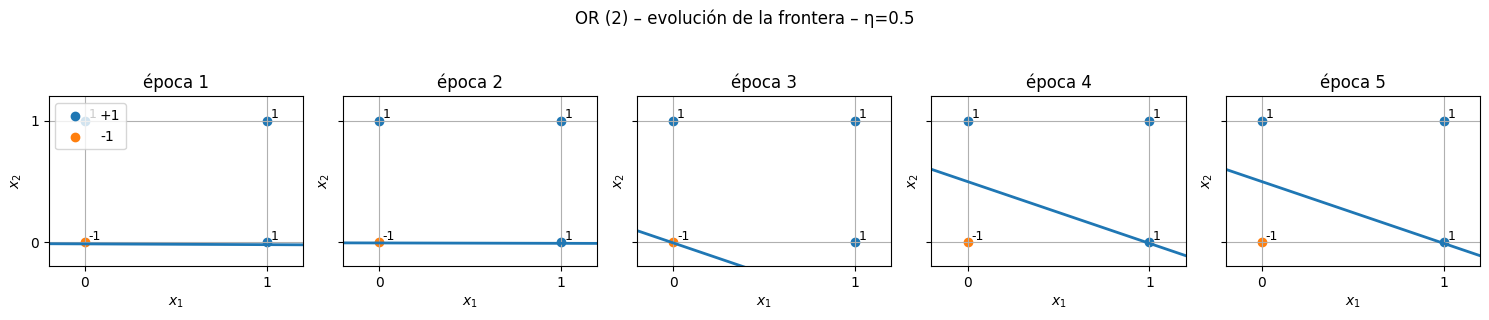

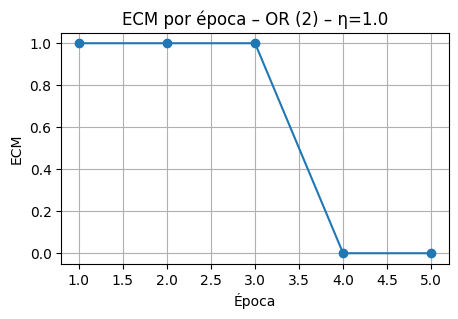

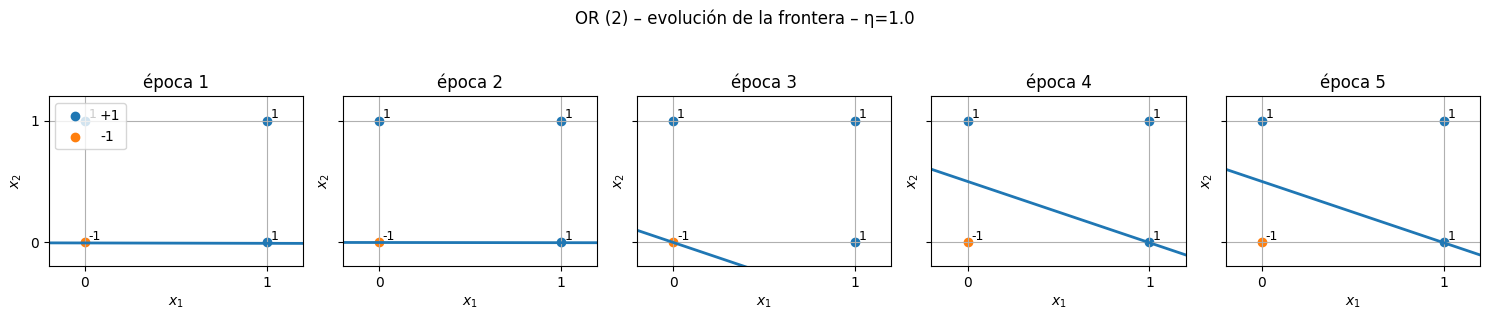

In [5]:
run_experiment_for_gate("OR", etas=[0.01, 0.05, 0.1, 0.5, 1.0], max_epochs=100, shuffle=False, random_state=42)


# 2. Determine num√©ricamente c√≥mo var√≠a la capacidad del perceptr√≥n simple en funci√≥n del n√∫mero de patrones ense√±ados. Q

## Experimento de Capacidad del Perceptr√≥n Simple

El objetivo es estimar **cu√°ntos patrones aleatorios puede aprender un perceptr√≥n simple con $N$ entradas**.  
La idea central es que el perceptr√≥n solo puede resolver problemas **linealmente separables**, es decir, aquellos donde existe un hiperplano en $\mathbb{R}^N$ que divide perfectamente a las dos clases.

---

### Metodolog√≠a del experimento

1. **Generaci√≥n de problemas aleatorios:**  
   - Se eligen $N$ (n√∫mero de entradas) y $N_p$ (n√∫mero de patrones).  
   - Cada patr√≥n es un vector $x \in [-1,1]^N$ generado al azar.  
   - A cada patr√≥n se le asigna una etiqueta $y \in \{-1,+1\}$ tambi√©n al azar.

2. **Entrenamiento del perceptr√≥n:**  
   - Se entrena con regla del perceptr√≥n cl√°sico hasta un m√°ximo de √©pocas.  
   - Se considera que el problema fue **aprendido** solo si el perceptr√≥n logra error de entrenamiento exactamente 0:
     $$
     \forall i,\;\; \hat{y}_i = y_i
     $$

3. **Estimaci√≥n de la fracci√≥n aprendida:**  
   - Se repite el procedimiento muchas veces (trials independientes).  
   - Se calcula:
     $$
     \text{frac}(N_p) \;=\; \frac{\# \text{problemas aprendidos}}{\text{trials}}
     $$

4. **Curvas de capacidad:**  
   - Para cada $N$, se var√≠a $N_p$ desde 1 hasta un m√∫ltiplo de $N$ (por ejemplo, $5N$).  
   - Se grafica la fracci√≥n aprendida en funci√≥n de $N_p$.  

---

### Qu√© vamos a medir

- Eje $x$: n√∫mero de patrones $N_p$.  
- Eje $y$: fracci√≥n de problemas aprendidos (probabilidad de separabilidad lineal).  

El resultado son curvas que empiezan en 1 (pocos patrones casi siempre separables) y decaen hacia 0 (muchos patrones casi nunca separables).  
El **punto medio** ($N_p^*$) se toma como la **capacidad emp√≠rica del perceptr√≥n**, definida como el n√∫mero de patrones que puede aprender en promedio.

---

### Resultado esperado

Seg√∫n la teor√≠a cl√°sica (Cover, 1965), la capacidad est√° en torno a:
$$
N_p^* \;\approx\; 2N
$$

Es decir, un perceptr√≥n simple puede aprender, en promedio, hasta aproximadamente el **doble de patrones que la cantidad de entradas** antes de que la probabilidad de √©xito caiga al 50%.


In [6]:
def _predict_from_w(X, w_aug):
    """Predicci√≥n {+1,-1} usando vector aumentado y pesos finales."""
    Xa = augment_with_bias(X)
    return np.where(Xa @ w_aug >= 0, 1, -1)

def _trial_learned_once(N: int, Np: int, eta=0.1, max_epochs=200, rng=None) -> bool:
    """
    Un problema aleatorio continuo:
      - X ~ U([-1,1]^N) de tama√±o Np
      - y ‚àà {-1,+1} al azar
    Entrena perceptr√≥n; True si clasifica 100% en training.
    """
    if rng is None:
        rng = np.random.default_rng()
    X = rng.uniform(-1.0, 1.0, size=(Np, N))
    y = rng.choice([-1, 1], size=Np)

    # random_state distinto por trial (para inicializaci√≥n)
    rs = int(rng.integers(0, 1_000_000))
    w_hist, _ = train_perceptron_aug_with_history(
        X, y, eta=eta, max_epochs=max_epochs, shuffle=False, random_state=rs
    )
    yhat = _predict_from_w(X, w_hist[-1])
    return bool(np.all(yhat == y))

def capacity_sweep(Ns, k_factor=5, trials=100, eta=0.1, max_epochs=500, seed=2025):
    """
    Para cada N y Np=1..k_factor*N, estima la fracci√≥n de problemas
    aprendidos (linealmente separables) por el perceptr√≥n.
    Devuelve: dict N -> (Np_values, frac_learned)
    """
    rng_master = np.random.default_rng(seed)
    results = {}
    for N in Ns:
        Np_vals = np.arange(1, k_factor * N + 1)
        fracs = np.empty_like(Np_vals, dtype=float)
        for j, Np in enumerate(Np_vals):
            success = 0
            for _ in range(trials):
                rng = np.random.default_rng(int(rng_master.integers(0, 1_000_000)))
                success += _trial_learned_once(N, int(Np), eta=eta, max_epochs=max_epochs, rng=rng)
            fracs[j] = success / trials
        results[N] = (Np_vals, fracs)
    return results

def half_capacity_point(Np_vals, fracs):
    """Np* donde la fracci√≥n est√° m√°s cerca de 0.5 (estimaci√≥n de capacidad)."""
    idx = int(np.argmin(np.abs(fracs - 0.5)))
    return int(Np_vals[idx]), float(fracs[idx])


## Experimento ejecutado: Capacidad emp√≠rica del perceptr√≥n simple

En este bloque de c√≥digo variamos **la dimensi√≥n del perceptr√≥n ($N$)** y el n√∫mero de **trials** (repeticiones del experimento aleatorio) para estimar de manera robusta la capacidad.

---

### Configuraci√≥n usada

- **Dimensiones comparadas ($N$):** $2, 4, 8, 20, 30$  
- **Cantidad de patrones probados ($N_p$):** desde 1 hasta $5 \cdot N$ (con `k_factor=5`).  
- **Tasa de aprendizaje:** $\eta = 0.1$  
- **√âpocas m√°ximas:** 500  
- **Semilla aleatoria:** 2854  
- **N√∫mero de trials:** $50$, $100$ y $500$

---

### Qu√© se midi√≥

1. Para cada $N$ y cada $N_p$, se generaron problemas aleatorios con entradas continuas en $[-1,1]^N$ y salidas en $\{-1,+1\}$.  
2. Se entren√≥ un perceptr√≥n simple y se cont√≥ como **aprendido** solo si alcanz√≥ **error de entrenamiento 0**.  
3. Se repiti√≥ el procedimiento varias veces (`trials`) y se calcul√≥ la **fracci√≥n de problemas aprendidos**:
   $$
   \text{frac}(N_p) \;=\; \frac{\# \text{problemas aprendidos}}{\text{trials}}
   $$
4. Se grafic√≥ la curva $\text{frac}(N_p)$ para cada $N$ y se marc√≥ con una l√≠nea roja punteada la referencia te√≥rica en $2N$.  

---

### Resultados esperados

- Las curvas comienzan cerca de 1 (cuando $N_p$ es chico, casi siempre son separables).  
- A medida que $N_p$ aumenta, la fracci√≥n de problemas aprendidos cae hacia 0.  
- El punto medio ($N_p^*$, donde la fracci√≥n ‚âà 0.5) aparece aproximadamente en $2N$, confirmando la predicci√≥n te√≥rica de que la capacidad del perceptr√≥n simple es cercana al doble de la dimensi√≥n de entrada.

---


In [7]:
# Config global
#Ns         = (2, 4, 8, 20, 30)     # dimensiones a comparar
Ns = (4,)
k_factor   = 5             # Np max = k_factor * N
eta        = 0.1
max_epochs = 500
seed       = 2854
#trials_list = [10, 50, 100, 500]
trials_list = []

for trials in trials_list:
    print(f"\n=== TRIALS = {trials} ===")
    results = capacity_sweep(
        Ns=Ns, k_factor=k_factor, trials=trials,
        eta=eta, max_epochs=max_epochs, seed=seed
    )

    # Plots por N
    for N, (Np_vals, fracs) in results.items():
        plt.figure(figsize=(5,3.5))
        plt.plot(Np_vals, fracs, marker='o', label="Fracci√≥n aprendida")

        # --- MARCA en 2N ---
        plt.axvline(2*N, color="red", linestyle="--", label=f"2N={2*N}")

        plt.xlabel("N√∫mero de patrones (Np)")
        plt.ylabel("Fracci√≥n aprendida")
        plt.title(f"Capacidad emp√≠rica ‚Äì Perceptr√≥n simple (N={N}) | trials={trials}")
        plt.ylim(-0.02, 1.02)
        plt.grid(True)
        plt.legend()
        plt.show()

    # Resumen de Np* (fracci√≥n ‚âà 0.5)
    print("Np* (aprox. fracci√≥n‚âà0.5) por N:")
    for N, (Np_vals, fracs) in results.items():
        Np_star, frac = half_capacity_point(Np_vals, fracs)
        print(f"  N={N}: Np*‚âà{Np_star} (fracci√≥n={frac:.2f})")


# 3. Implemente un perceptr√≥n multicapa que aprenda la funci√≥n l√≥gica XOR de 2 y de 4 entradas (utilizando el algoritmo Backpropagation y actualizando en batch). Muestre c√≥mo evoluciona el error durante el entrenamiento. 

Este c√≥digo implementa una red neuronal multicapa (MLP)

### 1. **Funciones de Activaci√≥n**

Las funciones de activaci√≥n son fundamentales para introducir no linealidad en el modelo, lo que le permite aprender representaciones complejas. El c√≥digo soporta las siguientes funciones de activaci√≥n:

- **Sigmoid**: 
  $$ \sigma(x) = \frac{1}{1 + e^{-x}} $$
  - La salida es entre 0 y 1. Com√∫nmente usada para problemas de clasificaci√≥n binaria.

- **Tanh**: 
  $$ \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $$
  - La salida es entre -1 y 1, y es √∫til cuando se necesita que los valores est√©n centrados alrededor de 0.

- **ReLU (Rectified Linear Unit)**: 
  $$ \text{ReLU}(x) = \max(0, x) $$
  - Amplia la activaci√≥n de las neuronas y es muy utilizada por su eficiencia computacional y su capacidad para evitar el desvanecimiento del gradiente.

- **Identidad (Linear)**: 
  $$ f(x) = x $$
  - Usada t√≠picamente en la capa de salida para problemas de regresi√≥n, donde la salida puede ser cualquier n√∫mero real.

Cada funci√≥n tiene tambi√©n su derivada correspondiente, que se usa durante el proceso de retropropagaci√≥n (backpropagation).

### 2. **Inicializaci√≥n de Pesos**

La **inicializaci√≥n de los pesos** en redes neuronales es crucial para un buen entrenamiento. En este c√≥digo, se utilizan dos m√©todos de inicializaci√≥n de pesos:

- **Inicializaci√≥n de Xavier/Glorot**: 
  Esta inicializaci√≥n es adecuada para funciones de activaci√≥n como **sigmoid**, **tanh** o **linear**. Los pesos se inicializan con una distribuci√≥n uniforme con el siguiente l√≠mite:
  $$ \text{limite} = \sqrt{\frac{6}{\text{fan\_in} + \text{fan\_out}}} $$

- **Inicializaci√≥n de He**: 
  Usada para **ReLU**. Se inicializan los pesos con una distribuci√≥n normal con desviaci√≥n est√°ndar:
  $$ \text{std} = \sqrt{\frac{2}{\text{fan\_in}}} $$

En ambos casos, los **bias** se inicializan a 0.

### 3. **Red Neuronal Multicapa (MLP)**

La clase `MLP` representa una red neuronal multicapa con la posibilidad de tener m√∫ltiples capas ocultas y de salida. Esta clase permite realizar las siguientes operaciones:

3.1 **Forward Pass**

El **forward pass** calcula la salida de la red para una entrada dada. Para cada capa, la salida se calcula como:

$$
Z = A \cdot W + b
$$
donde \( A \) es la activaci√≥n de la capa anterior, \( W \) es el peso de la capa actual, y \( b \) es el bias.

La salida de cada capa se pasa a trav√©s de la funci√≥n de activaci√≥n correspondiente.

3.2 **Backward Pass (Retropropagaci√≥n)**

En el **backpropagation**, se calculan los gradientes de los pesos y biases con respecto a la p√©rdida usando la regla de la cadena. La derivada de la funci√≥n de activaci√≥n se aplica a los errores para ajustar los pesos de la red.

La f√≥rmula para calcular los gradientes de los pesos y biases es:

$$
\delta_i = g'(Z_i) \cdot (C_i - O_i)
$$
donde \( \delta_i \) es el error de la capa \( i \), \( g'(Z_i) \) es la derivada de la activaci√≥n, y \( C_i \) y \( O_i \) son el valor objetivo y la salida de la red, respectivamente.

3.3 **Actualizaci√≥n de Pesos**

Despu√©s de calcular los gradientes, los pesos y biases se actualizan usando la regla de gradiente descendente. El aprendizaje es controlado por la tasa de aprendizaje (\( \eta \)):

$$
W_i = W_i - \eta \cdot \nabla W_i
$$
donde \( \nabla W_i \) es el gradiente de los pesos.

### 4. **Entrenamiento (fit)**

El m√©todo `fit()` entrena la red utilizando **mini-batches**. Durante el entrenamiento, la red realiza un **forward pass**, calcula la p√©rdida, realiza el **backward pass** y actualiza los pesos con la regla de gradiente descendente. El error de la red se guarda durante cada √©poca de entrenamiento, y el modelo se eval√∫a con un conjunto de validaci√≥n si se proporciona.

- **Early Stopping**: Si se proporciona un conjunto de validaci√≥n, el entrenamiento puede detenerse temprano si el error de validaci√≥n deja de mejorar despu√©s de un n√∫mero de √©pocas.

### 5. **Predicci√≥n**

El m√©todo `predict()` se utiliza para realizar predicciones usando el modelo entrenado. Devuelve la salida de la red para un conjunto de entradas.

### 6. **Clasificaci√≥n**

El m√©todo `predict_classes()` devuelve las predicciones de clase para problemas de clasificaci√≥n. Si la salida es binaria (solo una neurona en la capa de salida), usa un umbral (por defecto 0.5) para decidir si la clase es 0 o 1. Si la salida es de varias clases (una neurona por clase), toma la clase con la activaci√≥n m√°s alta.

---

Este c√≥digo implementa una red neuronal completa con m√∫ltiples capas ocultas y de salida, y proporciona los elementos necesarios para entrenar y hacer predicciones en tareas de clasificaci√≥n y regresi√≥n. La inicializaci√≥n de los pesos y las funciones de activaci√≥n juegan un papel clave en la eficiencia del entrenamiento y el rendimiento del modelo.


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Utilidades: activaciones
# ------------------------------
class Activations:
    @staticmethod
    def sigmoid(x):
        # num√©ricamente estable
        x = np.clip(x, -60, 60)
        return 1.0 / (1.0 + np.exp(-x))

    @staticmethod
    def d_sigmoid(a):
        # derivada en funci√≥n de la salida activada (a = sigmoid(x))
        return a * (1.0 - a)

    @staticmethod
    def tanh(x):
        # np.tanh ya es estable
        return np.tanh(x)

    @staticmethod
    def d_tanh(a):
        # derivada en funci√≥n de la salida activada (a = tanh(x))
        return 1.0 - a**2

    @staticmethod
    def relu(x):
        return np.maximum(0.0, x)

    @staticmethod
    def d_relu(a):
        return (a > 0.0).astype(a.dtype)

    @staticmethod
    def identity(x):
        return x

    @staticmethod
    def d_identity(a):
        return np.ones_like(a)

ACTS = {
    "sigmoid": (Activations.sigmoid, Activations.d_sigmoid),
    "tanh":    (Activations.tanh,    Activations.d_tanh),
    "relu":    (Activations.relu,    Activations.d_relu),
    "linear":  (Activations.identity,Activations.d_identity),
    "identity":(Activations.identity,Activations.d_identity),
}

# ------------------------------
# Inicializaci√≥n de pesos
# ------------------------------
def weight_init(fan_in, fan_out, act_name, rng):
    """
    Xavier (sigmoid/tanh/linear) o He (ReLU). Retorna W, b.
    """
    act = act_name.lower()
    if act in ("relu",):
        # He normal
        std = np.sqrt(2.0 / fan_in)
    else:
        # Xavier/Glorot uniforme
        limit = np.sqrt(6.0 / (fan_in + fan_out))
        W = rng.uniform(-limit, limit, size=(fan_in, fan_out))
        b = np.zeros((1, fan_out))
        return W, b

    W = rng.normal(0.0, std, size=(fan_in, fan_out))
    b = np.zeros((1, fan_out))
    return W, b

# ------------------------------
# MLP
# ------------------------------
class MLP:
    def __init__(
        self,
        layer_sizes,                          # lista: [n_in, h1, h2, ..., n_out]
        activations,                          # lista de nombres p/ cada capa no-lineal (len = len(layer_sizes)-1)
        seed=42,
        l2=0.0,
        learning_rate=0.05,
        clip_grad=None,                       # e.g. 5.0 para clipping global (norma)
        dtype=np.float64
    ):
        self.layer_sizes = layer_sizes
        self.activations = [a.lower() for a in activations]
        self.rng = np.random.default_rng(seed)
        self.l2 = float(l2)
        self.lr = float(learning_rate)
        self.clip_grad = clip_grad
        self.dtype = dtype

        # Pesos y biases
        self.W = []
        self.b = []
        for l in range(len(layer_sizes)-1):
            fan_in, fan_out = layer_sizes[l], layer_sizes[l+1]
            Wi, bi = weight_init(fan_in, fan_out, self.activations[l], self.rng)
            self.W.append(Wi.astype(dtype))
            self.b.append(bi.astype(dtype))

        # Cache para forward
        self._Z = []  # preactivaciones (linear)
        self._A = []  # activaciones (post g)

    # ---------- Forward ----------
    def forward(self, X, store_cache=True):
        A = X.astype(self.dtype, copy=False)
        if store_cache:
            self._Z = []
            self._A = [A]  # guardar entrada como A0
        for l, act_name in enumerate(self.activations):
            Z = A @ self.W[l] + self.b[l]              # (batch, fan_out)
            act, _ = ACTS[act_name]
            A = act(Z)
            if store_cache:
                self._Z.append(Z)
                self._A.append(A)
        return A

    # ---------- P√©rdida (ECM) ----------
    @staticmethod
    def mse(y_true, y_pred):
        return 0.5 * np.mean((y_true - y_pred)**2)

    # ---------- Backprop ----------
    def backward(self, y_true, y_pred):
        batch = y_true.shape[0]
        deltas = [None] * len(self.W)
        dW = [None] * len(self.W)
        db = [None] * len(self.W)

        l = len(self.W) - 1
        _, d_act = ACTS[self.activations[l]]
        A_L = self._A[-1]
        dE_dA = (A_L - y_true) / batch
        delta = d_act(A_L) * dE_dA
        deltas[l] = delta
        dW[l] = self._A[l].T @ delta + self.l2 * self.W[l]   
        db[l] = np.sum(delta, axis=0, keepdims=True)

        for l in range(len(self.W)-2, -1, -1):
            _, d_act = ACTS[self.activations[l]]
            A_l = self._A[l+1]
            Z_l = self._Z[l]
            delta = (deltas[l+1] @ self.W[l+1].T) * d_act(A_l)
            deltas[l] = delta
            dW[l] = self._A[l].T @ delta + self.l2 * self.W[l]
            db[l] = np.sum(delta, axis=0, keepdims=True)

        if self.clip_grad is not None:
            total_norm = 0.0
            for g in dW + db:
                total_norm += np.sum(g*g)
            total_norm = np.sqrt(total_norm)
            if total_norm > self.clip_grad:
                factor = self.clip_grad / (total_norm + 1e-12)
                for i in range(len(dW)):
                    dW[i] *= factor
                    db[i] *= factor

        return dW, db

    # ---------- Update (SGD) ----------
    def step(self, dW, db):
        for i in range(len(self.W)):
            self.W[i] -= self.lr * dW[i]
            self.b[i] -= self.lr * db[i]

    def fit(self, X, y, epochs=2000, batch_size=32, shuffle=True, X_val=None, y_val=None, early_stopping=False, patience=50, verbose=True, log_every=50):
        X = X.astype(self.dtype, copy=False)
        y = y.astype(self.dtype, copy=False)
        
        if X.shape[0] != y.shape[0]:
            raise ValueError(f"Las dimensiones de X y y no coinciden: X tiene {X.shape[0]} muestras, y tiene {y.shape[0]} muestras.")
        
        n = X.shape[0]
        history = {"loss": [], "val_loss": []}
        
        for epoch in range(1, epochs + 1):
            if shuffle:
                idx = np.random.permutation(n)
                X, y = X[idx], y[idx]

            for start in range(0, n, batch_size):
                end = min(start + batch_size, n)  
                Xb = X[start:end]
                yb = y[start:end]

                y_pred = self.forward(Xb, store_cache=True)
                dW, db = self.backward(yb, y_pred)
                self.step(dW, db)

            train_pred = self.forward(X, store_cache=False)
            loss = self.mse(y, train_pred)
            history["loss"].append(loss)

            if X_val is not None and y_val is not None:
                val_pred = self.forward(X_val, store_cache=False)
                val_loss = self.mse(y_val, val_pred)
                history["val_loss"].append(val_loss)

            if early_stopping and val_loss is not None:
                if val_loss + 1e-12 < best_val:
                    best_val = val_loss
                    wait = 0
                    best_state = (
                        [Wi.copy() for Wi in self.W],
                        [bi.copy() for bi in self.b],
                    )
                else:
                    wait += 1
                    if wait >= patience:
                        if verbose:
                            print(f"Early stopping en epoch {epoch}. Mejor val_loss = {best_val:.6f}")
                        if best_state is not None:
                            self.W, self.b = best_state
                        break

            if verbose and (epoch % log_every == 0 or epoch == 1 or epoch == epochs):
                msg = f"[{epoch:4d}] loss={loss:.6f}"
                if val_loss is not None:
                    msg += f" | val_loss={val_loss:.6f}"
                print(msg)

            if early_stopping and wait >= patience:
                break

        return history

    # ---------- Predicci√≥n ----------
    def predict(self, X):
        return self.forward(X, store_cache=False)

    # ---------- Helpers para clasificaci√≥n ----------
    def predict_classes(self, X, threshold=0.5):
        yhat = self.predict(X)
        if yhat.shape[1] == 1:
            return (yhat >= threshold).astype(int)
        else:
            return np.argmax(yhat, axis=1)


Entrenando con Red 2 -> 2 -> 1 (Sigmoid) - LR: 0.01...
√öltimo error: 0.125635
Error promedio: 0.126168
Desviaci√≥n est√°ndar del error: 0.000377
La red no ha convergido completamente, puede ser necesario ajustar par√°metros.


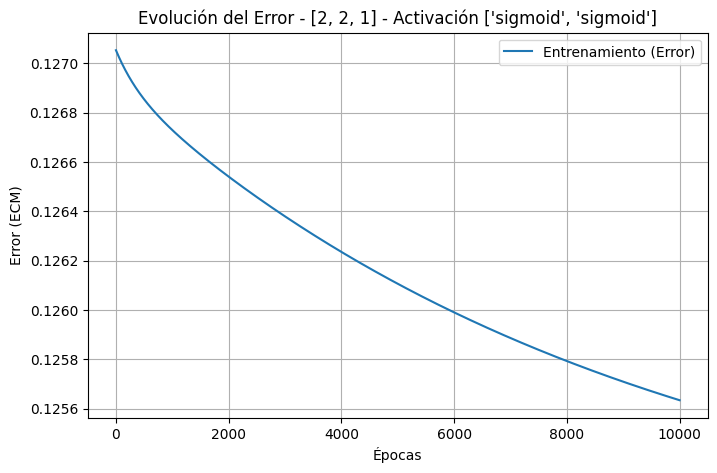

Entrenando con Red 2 -> 4 -> 1 (Sigmoid) - LR: 0.05...
√öltimo error: 0.112105
Error promedio: 0.121430
Desviaci√≥n est√°ndar del error: 0.003596
La red no ha convergido completamente, puede ser necesario ajustar par√°metros.


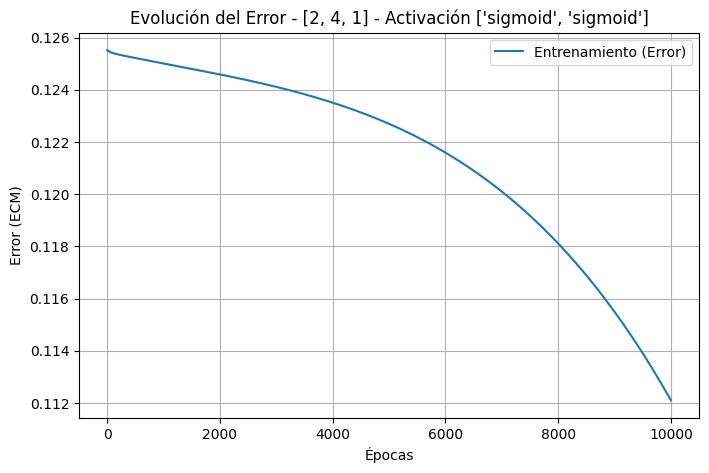

Entrenando con Red 2 -> 4 -> 4 -> 1 (Sigmoid) - LR: 0.1...
√öltimo error: 0.123527
Error promedio: 0.124592
Desviaci√≥n est√°ndar del error: 0.000659
La red no ha convergido completamente, puede ser necesario ajustar par√°metros.


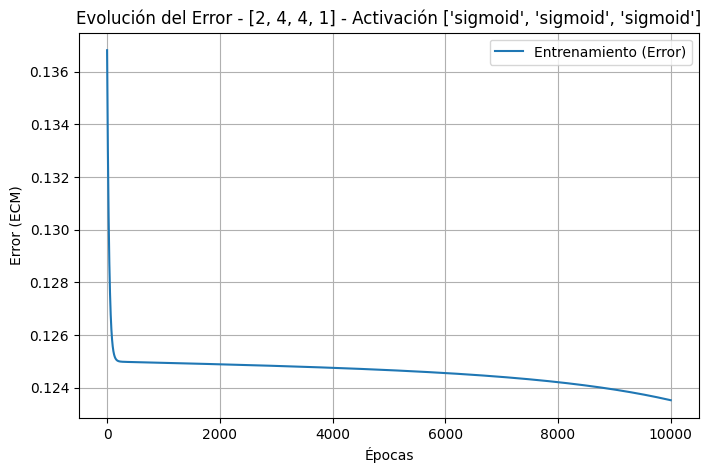

Entrenando con Red 2 -> 8 -> 8 -> 1 (Sigmoid) - LR: 0.1...
√öltimo error: 0.124960
Error promedio: 0.125031
Desviaci√≥n est√°ndar del error: 0.000168
La red no ha convergido completamente, puede ser necesario ajustar par√°metros.


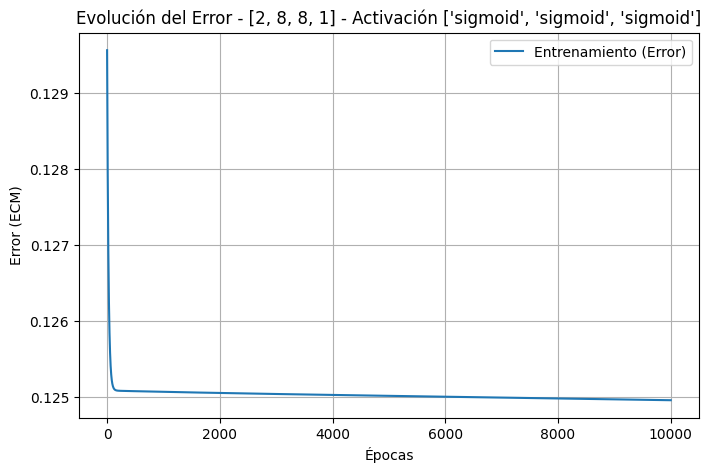

Entrenando con Red 2 -> 2 -> 1 (Sigmoid) - LR: 0.1...
√öltimo error: 0.114477
Error promedio: 0.123620
Desviaci√≥n est√°ndar del error: 0.002687
La red no ha convergido completamente, puede ser necesario ajustar par√°metros.


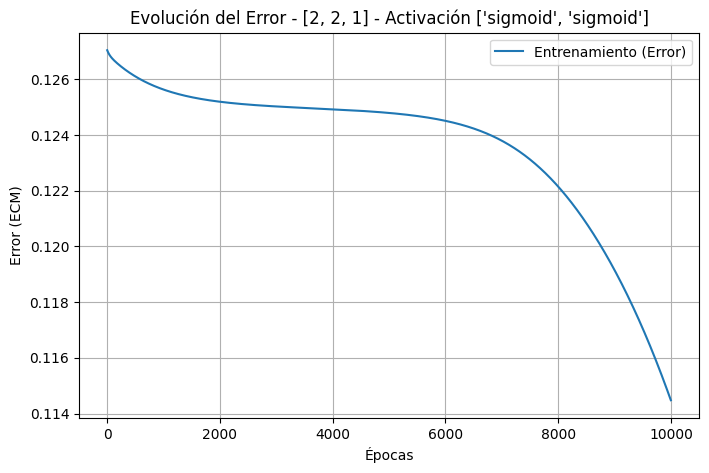

Entrenando con Red 2 -> 2 -> 1 (Tanh) - LR: 0.01...
√öltimo error: 0.002957
Error promedio: 0.041051
Desviaci√≥n est√°ndar del error: 0.044363
La red parece haber convergido con √©xito.


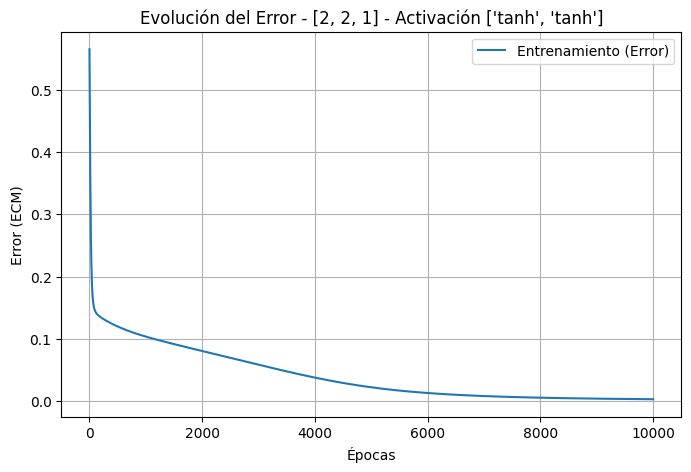

Entrenando con Red 2 -> 4 -> 1 (Tanh) - LR: 0.05...
√öltimo error: 0.000212
Error promedio: 0.006412
Desviaci√≥n est√°ndar del error: 0.020126
La red parece haber convergido con √©xito.


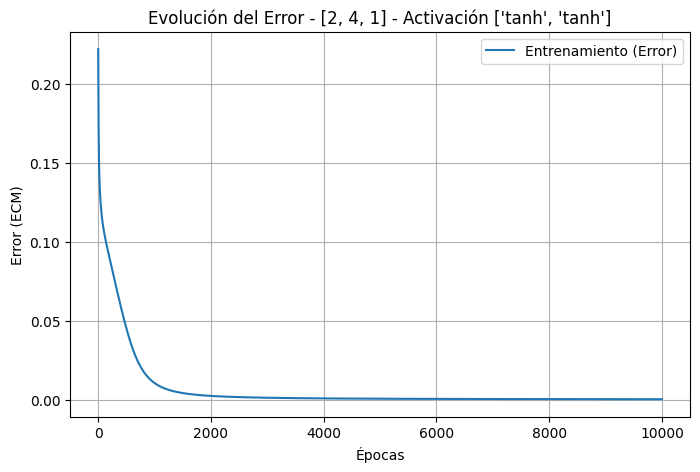

Entrenando con Red 2 -> 4 -> 4 -> 1 (Tanh) - LR: 0.05...
√öltimo error: 0.000109
Error promedio: 0.005462
Desviaci√≥n est√°ndar del error: 0.020673
La red parece haber convergido con √©xito.


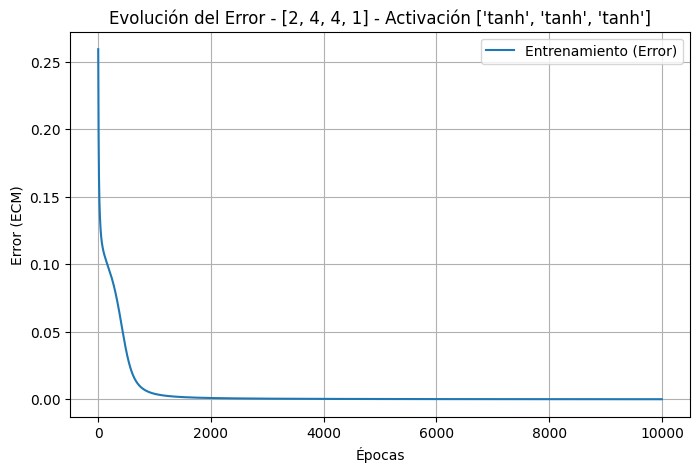

Entrenando con Red 2 -> 8 -> 8 -> 1 (Tanh) - LR: 0.1...
√öltimo error: 0.000033
Error promedio: 0.002965
Desviaci√≥n est√°ndar del error: 0.015553
La red parece haber convergido con √©xito.


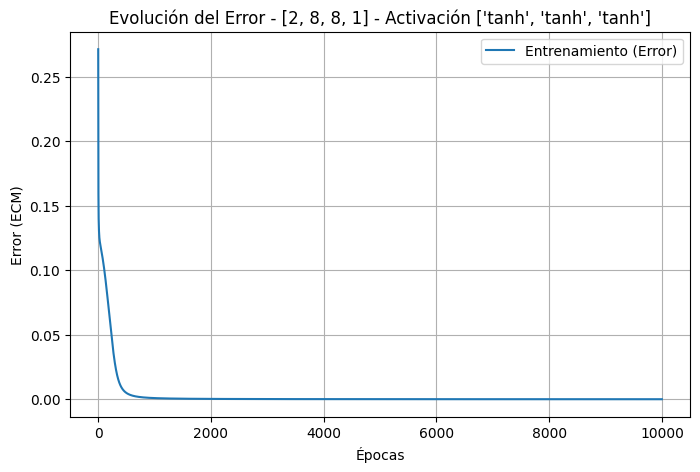

Entrenando con Red 2 -> 2 -> 1 (Tanh) - LR: 0.05...
√öltimo error: 0.000183
Error promedio: 0.008680
Desviaci√≥n est√°ndar del error: 0.025346
La red parece haber convergido con √©xito.


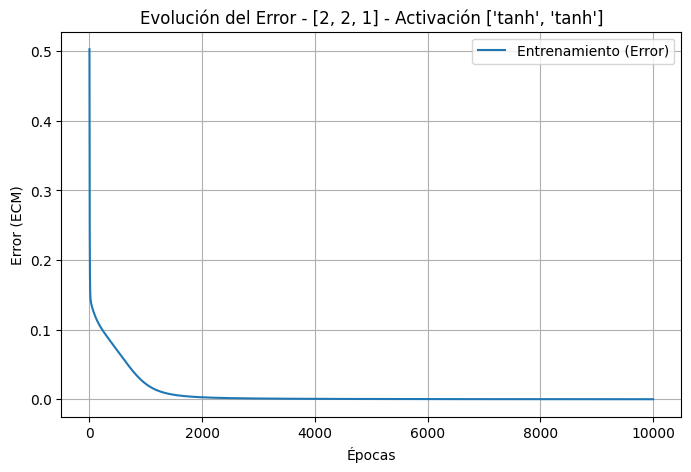

Entrenando con Red 4 -> 2 -> 1 (Sigmoid) - LR: 0.01...
√öltimo error: 0.125165
Error promedio: 0.125491
Desviaci√≥n est√°ndar del error: 0.001253
La red no ha convergido completamente, puede ser necesario ajustar par√°metros.


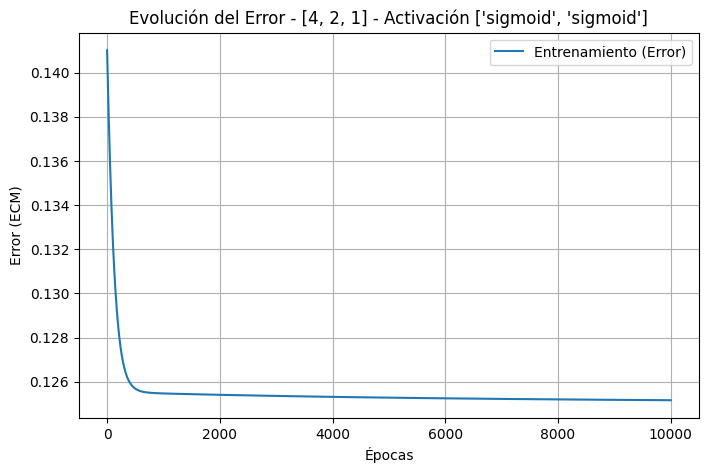

Entrenando con Red 4 -> 4 -> 1 (Sigmoid) - LR: 0.05...
√öltimo error: 0.124998
Error promedio: 0.125074
Desviaci√≥n est√°ndar del error: 0.000099
La red no ha convergido completamente, puede ser necesario ajustar par√°metros.


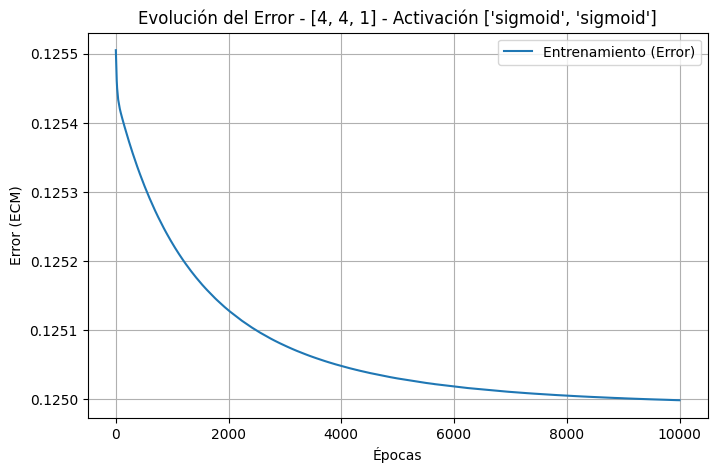

Entrenando con Red 4 -> 4 -> 4 -> 1 (Sigmoid) - LR: 0.1...
√öltimo error: 0.125005
Error promedio: 0.125073
Desviaci√≥n est√°ndar del error: 0.000789
La red no ha convergido completamente, puede ser necesario ajustar par√°metros.


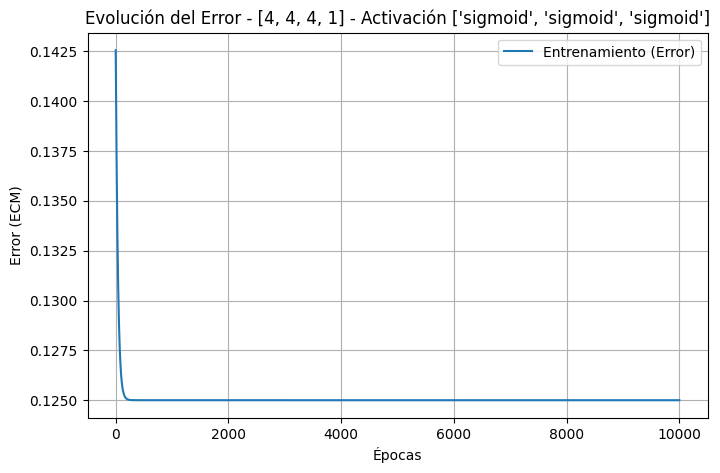

Entrenando con Red 4 -> 8 -> 8 -> 1 (Sigmoid) - LR: 0.1...
√öltimo error: 0.125004
Error promedio: 0.125014
Desviaci√≥n est√°ndar del error: 0.000086
La red no ha convergido completamente, puede ser necesario ajustar par√°metros.


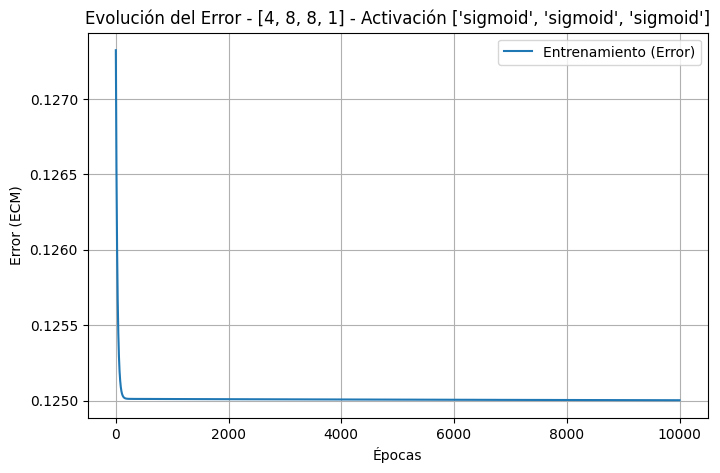

Entrenando con Red 4 -> 2 -> 1 (Sigmoid) - LR: 0.1...
√öltimo error: 0.125052
Error promedio: 0.125252
Desviaci√≥n est√°ndar del error: 0.000810
La red no ha convergido completamente, puede ser necesario ajustar par√°metros.


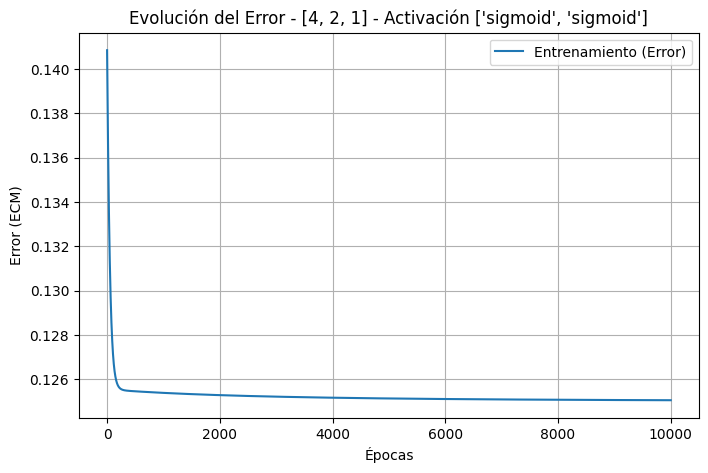

Entrenando con Red 4 -> 2 -> 1 (Tanh) - LR: 0.01...
√öltimo error: 0.124980
Error promedio: 0.125937
Desviaci√≥n est√°ndar del error: 0.011294
La red no ha convergido completamente, puede ser necesario ajustar par√°metros.


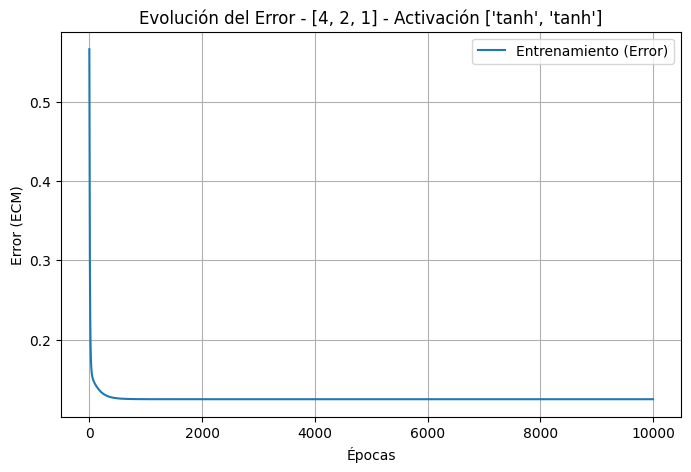

Entrenando con Red 4 -> 4 -> 1 (Tanh) - LR: 0.05...
√öltimo error: 0.000591
Error promedio: 0.024967
Desviaci√≥n est√°ndar del error: 0.036457
La red parece haber convergido con √©xito.


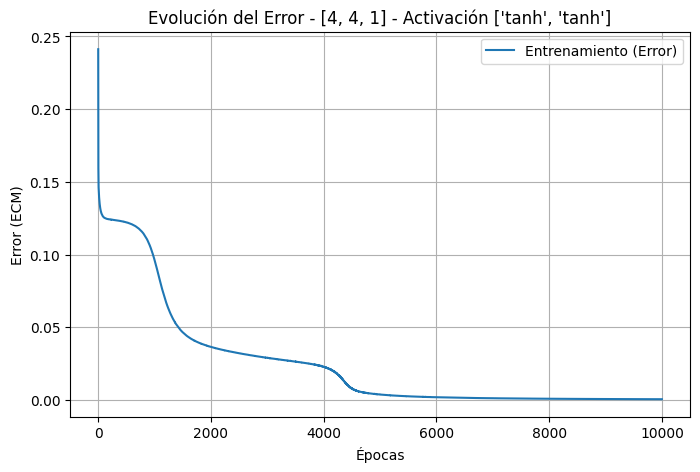

Entrenando con Red 4 -> 4 -> 4 -> 1 (Tanh) - LR: 0.1...
√öltimo error: 0.000148
Error promedio: 0.026943
Desviaci√≥n est√°ndar del error: 0.046153
La red parece haber convergido con √©xito.


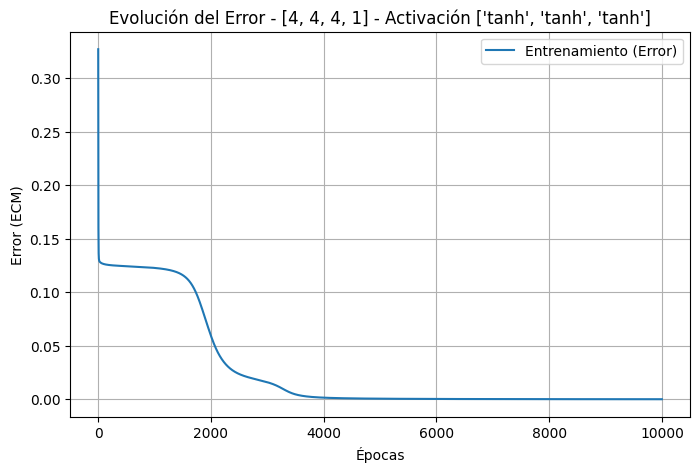

Entrenando con Red 4 -> 8 -> 8 -> 1 (Tanh) - LR: 0.1...
√öltimo error: 0.000104
Error promedio: 0.014973
Desviaci√≥n est√°ndar del error: 0.032234
La red parece haber convergido con √©xito.


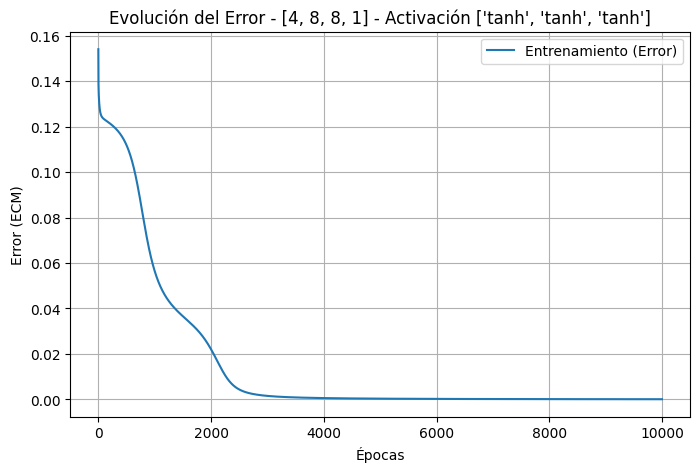

Entrenando con Red 4 -> 2 -> 1 (Tanh) - LR: 0.05...
√öltimo error: 0.124978
Error promedio: 0.125736
Desviaci√≥n est√°ndar del error: 0.009956
La red no ha convergido completamente, puede ser necesario ajustar par√°metros.


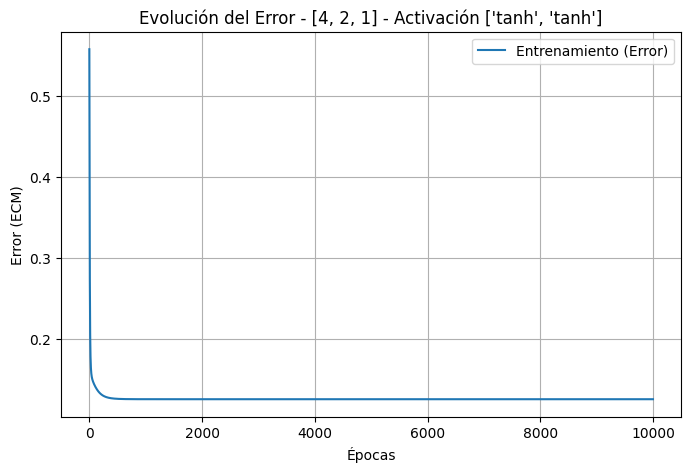

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import csv

# ------------------------------
# Definir los datos XOR de 2 y 4 entradas
# ------------------------------
# XOR de 2 entradas
X_2 = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_2 = np.array([[0], [1], [1], [0]])  # Salida XOR para 2 entradas

# XOR de 4 entradas (simplemente extendiendo el conjunto XOR original)
X_4 = np.array([[0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 1],
                [0, 1, 0, 0], [0, 1, 0, 1], [0, 1, 1, 0], [0, 1, 1, 1],
                [1, 0, 0, 0], [1, 0, 0, 1], [1, 0, 1, 0], [1, 0, 1, 1],
                [1, 1, 0, 0], [1, 1, 0, 1], [1, 1, 1, 0], [1, 1, 1, 1]])

# Ajustar y_4 para que tenga el mismo tama√±o que X_4
y_4 = np.array([[0], [1], [1], [0], [1], [0], [0], [1], [1], [0], [0], [1], [0], [1], [1], [0]])  # Salida XOR para 4 entradas

# ============================
# Funci√≥n para entrenar la red
# ============================
def train_and_plot(X, y, layer_sizes, activations, epochs=10000, batch_size=4, learning_rate=0.1):
    """
    Esta funci√≥n entrena la red neuronal y grafica la evoluci√≥n del error durante el entrenamiento.

    Par√°metros:
    - X: datos de entrada.
    - y: etiquetas de salida.
    - layer_sizes: lista con el tama√±o de las capas [entrada, capa_1, capa_2, ..., salida].
    - activations: lista de funciones de activaci√≥n para cada capa.
    - epochs: n√∫mero de √©pocas de entrenamiento.
    - batch_size: tama√±o del batch.
    - learning_rate: tasa de aprendizaje.
    """
    # Crear la red
    mlp = MLP(layer_sizes=layer_sizes, activations=activations, learning_rate=learning_rate)

    # Entrenar
    history = mlp.fit(X, y, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=False)

    # Mostrar informaci√≥n clave del historial
    final_loss = history["loss"][-1]  # √öltimo error
    avg_loss = np.mean(history["loss"])  # Promedio del error
    std_loss = np.std(history["loss"])  # Desviaci√≥n est√°ndar del error

    print(f"√öltimo error: {final_loss:.6f}")
    print(f"Error promedio: {avg_loss:.6f}")
    print(f"Desviaci√≥n est√°ndar del error: {std_loss:.6f}")
     # Determinar si la red convergi√≥ (por ejemplo, si el error final es suficientemente bajo)
    if final_loss < 0.05:
        print("La red parece haber convergido con √©xito.")
    else:
        print("La red no ha convergido completamente, puede ser necesario ajustar par√°metros.")
        
    # Graficar la evoluci√≥n del error
    plt.figure(figsize=(8, 5))
    plt.plot(history["loss"], label='Entrenamiento (Error)')
    plt.xlabel('√âpocas')
    plt.ylabel('Error (ECM)')
    plt.title(f'Evoluci√≥n del Error - {layer_sizes} - Activaci√≥n {activations}')
    plt.legend()
    plt.grid(True)
    plt.show()



# ============================
# Probar varias configuraciones (XOR con 2 entradas)
# ============================

# 1. Red simple con 2 capas (oculta y salida) y activaci√≥n Sigmoid, learning rate 0.01
print("Entrenando con Red 2 -> 2 -> 1 (Sigmoid) - LR: 0.01...")
train_and_plot(X_2, y_2, layer_sizes=[2, 2, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.01)

# 2. Red con m√°s neuronas en la capa oculta (2 -> 4 -> 1) y activaci√≥n Sigmoid, learning rate 0.05
print("Entrenando con Red 2 -> 4 -> 1 (Sigmoid) - LR: 0.05...")
train_and_plot(X_2, y_2, layer_sizes=[2, 4, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.05)

# 3. Red con 2 capas ocultas para 2 entradas (2 -> 4 -> 4 -> 1) con activaci√≥n Sigmoid, learning rate 0.1
print("Entrenando con Red 2 -> 4 -> 4 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_2, y_2, layer_sizes=[2, 4, 4, 1], activations=["sigmoid", "sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.1)

# 4. Red con 2 entradas y m√°s complejidad (2 -> 8 -> 8 -> 1) con activaci√≥n Sigmoid, learning rate 0.1
print("Entrenando con Red 2 -> 8 -> 8 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_2, y_2, layer_sizes=[2, 8, 8, 1], activations=["sigmoid", "sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.1)

# 5. Red muy simple para 2 entradas con solo una capa oculta peque√±a (2 -> 2 -> 1) con activaci√≥n Sigmoid, learning rate 0.1
print("Entrenando con Red 2 -> 2 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_2, y_2, layer_sizes=[2, 2, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.1)

# 6. Red simple con 2 capas (oculta y salida) y activaci√≥n Tanh, learning rate 0.01
print("Entrenando con Red 2 -> 2 -> 1 (Tanh) - LR: 0.01...")
train_and_plot(X_2, y_2, layer_sizes=[2, 2, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.01)

# 7. Red con m√°s neuronas en la capa oculta (2 -> 4 -> 1) y activaci√≥n Tanh, learning rate 0.05
print("Entrenando con Red 2 -> 4 -> 1 (Tanh) - LR: 0.05...")
train_and_plot(X_2, y_2, layer_sizes=[2, 4, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.05)

# 8. Red con 2 capas ocultas para 2 entradas (2 -> 4 -> 4 -> 1) con activaci√≥n Tanh, learning rate 0.05
print("Entrenando con Red 2 -> 4 -> 4 -> 1 (Tanh) - LR: 0.05...")
train_and_plot(X_2, y_2, layer_sizes=[2, 4, 4, 1], activations=["tanh", "tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.05)

# 9. Red con 2 entradas y m√°s complejidad (2 -> 8 -> 8 -> 1) con activaci√≥n Tanh, learning rate 0.1
print("Entrenando con Red 2 -> 8 -> 8 -> 1 (Tanh) - LR: 0.1...")
train_and_plot(X_2, y_2, layer_sizes=[2, 8, 8, 1], activations=["tanh", "tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.1)

# 10. Red muy simple para 2 entradas con solo una capa oculta peque√±a (2 -> 2 -> 1) con activaci√≥n Tanh, learning rate 0.05
print("Entrenando con Red 2 -> 2 -> 1 (Tanh) - LR: 0.05...")
train_and_plot(X_2, y_2, layer_sizes=[2, 2, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.05)

# ============================
# Probar varias configuraciones (XOR con 4 entradas)
# ============================

# 1. Red simple con 2 capas (oculta y salida) y activaci√≥n Sigmoid, learning rate 0.01
print("Entrenando con Red 4 -> 2 -> 1 (Sigmoid) - LR: 0.01...")
train_and_plot(X_4, y_4, layer_sizes=[4, 2, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.01)

# 2. Red con m√°s neuronas en la capa oculta (4 -> 4 -> 1) y activaci√≥n Sigmoid, learning rate 0.05
print("Entrenando con Red 4 -> 4 -> 1 (Sigmoid) - LR: 0.05...")
train_and_plot(X_4, y_4, layer_sizes=[4, 4, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.05)

# 3. Red con 2 capas ocultas para 4 entradas (4 -> 4 -> 4 -> 1) con activaci√≥n Sigmoid, learning rate 0.1
print("Entrenando con Red 4 -> 4 -> 4 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_4, y_4, layer_sizes=[4, 4, 4, 1], activations=["sigmoid", "sigmoid", "sigmoid"], epochs=10000, batch_size=16, learning_rate=0.1)

# 4. Red con 4 entradas y m√°s complejidad (4 -> 8 -> 8 -> 1) con activaci√≥n Sigmoid, learning rate 0.1
print("Entrenando con Red 4 -> 8 -> 8 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_4, y_4, layer_sizes=[4, 8, 8, 1], activations=["sigmoid", "sigmoid", "sigmoid"], epochs=10000, batch_size=16, learning_rate=0.1)

# 5. Red muy simple para 4 entradas con solo una capa oculta peque√±a (4 -> 2 -> 1) con activaci√≥n Sigmoid, learning rate 0.1
print("Entrenando con Red 4 -> 2 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_4, y_4, layer_sizes=[4, 2, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=16, learning_rate=0.1)

# 6. Red simple con 2 capas (oculta y salida) y activaci√≥n Tanh, learning rate 0.01
print("Entrenando con Red 4 -> 2 -> 1 (Tanh) - LR: 0.01...")
train_and_plot(X_4, y_4, layer_sizes=[4, 2, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.01)

# 7. Red con m√°s neuronas en la capa oculta (4 -> 4 -> 1) y activaci√≥n Tanh, learning rate 0.05
print("Entrenando con Red 4 -> 4 -> 1 (Tanh) - LR: 0.05...")
train_and_plot(X_4, y_4, layer_sizes=[4, 4, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.05)

# 8. Red con 2 capas ocultas para 4 entradas (4 -> 4 -> 4 -> 1) con activaci√≥n Tanh, learning rate 0.1
print("Entrenando con Red 4 -> 4 -> 4 -> 1 (Tanh) - LR: 0.1...")
train_and_plot(X_4, y_4, layer_sizes=[4, 4, 4, 1], activations=["tanh", "tanh", "tanh"], epochs=10000, batch_size=16, learning_rate=0.1)

# 9. Red con 4 entradas y m√°s complejidad (4 -> 8 -> 8 -> 1) con activaci√≥n Tanh, learning rate 0.1
print("Entrenando con Red 4 -> 8 -> 8 -> 1 (Tanh) - LR: 0.1...")
train_and_plot(X_4, y_4, layer_sizes=[4, 8, 8, 1], activations=["tanh", "tanh", "tanh"], epochs=10000, batch_size=16, learning_rate=0.1)

# 10. Red muy simple para 4 entradas con solo una capa oculta peque√±a (4 -> 2 -> 1) con activaci√≥n Tanh, learning rate 0.05
print("Entrenando con Red 4 -> 2 -> 1 (Tanh) - LR: 0.05...")
train_and_plot(X_4, y_4, layer_sizes=[4, 2, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=16, learning_rate=0.05)


### Conclusi√≥n:

Los resultados obtenidos a partir de las pruebas realizadas con la red neuronal para el problema XOR, utilizando diferentes funciones de activaci√≥n (Sigmoid y Tanh) y varios **learning rates**, ofrecen una serie de observaciones clave sobre el comportamiento de la red:

1. **Funci√≥n Sigmoide**:
   - A pesar de entrenar durante **10,000 epochs**, las redes con funci√≥n de activaci√≥n **Sigmoid** no parecen haber convergido completamente. 
   - Aunque los **errores** alcanzan valores bajos, la red muestra **una estabilidad constante** en cuanto al error, pero no logra minimizarlo completamente.
   - **El learning rate** juega un papel fundamental, pero **Sigmoid** sigue sin ofrecer una convergencia ideal en configuraciones m√°s complejas. En redes m√°s peque√±as, los valores de error son mejores, pero no se logra una **convergencia perfecta**.
   
2. **Funci√≥n Tanh**:
   - **Tanh**, por otro lado, muestra un **rendimiento superior** en la mayor√≠a de las configuraciones de red. Con **learning rates m√°s bajos** (como 0.01 y 0.05), la red **converge mucho m√°s r√°pido** y los **errores finales** se mantienen muy bajos, a menudo cercanos a cero.
   - La **desviaci√≥n est√°ndar** tambi√©n es m√°s peque√±a, lo que indica que la red es m√°s estable en su proceso de entrenamiento.
   - Las redes con **Tanh** parecen **aprender de manera m√°s eficiente**, y los resultados muestran una convergencia **m√°s r√°pida y precisa** en comparaci√≥n con **Sigmoid**.

3. **Impacto del n√∫mero de capas y neuronas**:
   - **Incrementar el n√∫mero de capas y neuronas** (como en las configuraciones 4 -> 4 -> 4 -> 1 o 4 -> 8 -> 8 -> 1) no siempre mejora el rendimiento. De hecho, en algunos casos, las redes m√°s complejas mostraron un mayor error debido a que no lograron converger correctamente. Esto sugiere que el aumento de la complejidad sin una **ajuste adecuado de los par√°metros** (como el learning rate) puede llevar a una **convergencia m√°s lenta o ineficiente**.
   
4. **Observaciones generales**:
   - **Learning rate**: La tasa de aprendizaje es un factor crucial en la convergencia de la red. En redes con **Tanh**, los **learning rates m√°s bajos** han dado mejores resultados. Sin embargo, para **Sigmoid**, puede que sea necesario un **learning rate m√°s alto** para mejorar la convergencia, pero incluso con valores altos, la red no logra converger completamente.
   - En resumen, **Tanh** resulta ser m√°s **eficaz y estable** en este caso en comparaci√≥n con **Sigmoid**.


# 4.a) Implemente una red con aprendizaje Backpropagation que aprenda la siguiente funci√≥n: $$ f(x, y, z) = \sin(x) + \cos(y) + z $$ donde: $$ x, y \in [0, 2\pi] \quad \text{y} \quad z \in [-1, 1] $$ Para ello construya un conjunto de datos de entrenamiento y un conjunto de evaluaci√≥n.  Muestre la evoluci√≥n del error de entrenamiento y de evaluaci√≥n en funci√≥n de las √©pocas de entrenamiento.


### Explicaci√≥n del experimento

Esta celda entrena una **red neuronal multicapa (MLP)** mediante *Backpropagation* para aprender la funci√≥n:

$$
f(x, y, z) = \sin(x) + \cos(y) + z
$$

---

#### üîπ Etapas del proceso

1. **Generaci√≥n del dataset**  
   Se crean muestras aleatorias de $(x, y, z)$ con:
   - $x, y \in [0, 2\pi]$
   - $z \in [-1, 1]$  
   Luego se calcula la salida real $f(x, y, z)$.  
   El conjunto total se divide en:
   - 80 % para entrenamiento  
   - 20 % para validaci√≥n

2. **Configuraci√≥n del modelo**  
   Se utiliza una red con:
   - 3 neuronas de entrada  
   - 30 neuronas en la capa oculta  
   - 1 neurona de salida  
   Las activaciones son:
   - `tanh` en la capa oculta  
   - `linear` en la salida  
   Par√°metros ajustados para estabilidad:
   - `learning_rate = 0.005`  
   - `l2 = 1e-4` (regularizaci√≥n suave)  
   - `clip_grad = 5.0` (evita saltos bruscos)  
   - `shuffle = False` (curvas de error m√°s limpias)

3. **Entrenamiento**  
   La red aprende durante **2000 √©pocas** con `batch_size = 32`, registrando el **error cuadr√°tico medio (MSE)** tanto en entrenamiento como en validaci√≥n.  
   Los par√°metros elegidos suavizan las oscilaciones del error y favorecen una convergencia m√°s estable.

4. **Evaluaci√≥n de resultados**  
   Se muestran:
   - El **MSE final** en entrenamiento y validaci√≥n  
   - Ejemplos de predicciones comparando el valor real con el predicho  
   - Un **gr√°fico de la evoluci√≥n del error**, donde se observa c√≥mo el modelo se ajusta progresivamente a la funci√≥n objetivo


Generando conjunto de datos...
 - Total de muestras: 2000
 - Entrenamiento: 1600 muestras
 - Validaci√≥n:    400 muestras

Configurando la red neuronal...
Iniciando entrenamiento...

Entrenamiento finalizado.

RESULTADOS FINALES
----------------------
MSE final (entrenamiento): 0.003917
MSE final (validaci√≥n):    0.004350

√âpoca  200 | MSE_train=0.064926 | MSE_val=0.070473
√âpoca 1000 | MSE_train=0.016219 | MSE_val=0.018387
√âpoca 1800 | MSE_train=0.004965 | MSE_val=0.005597
√âpoca 2000 | MSE_train=0.003917 | MSE_val=0.004350

Ejemplos de predicci√≥n:
    [x, y, z]  ->  f_real   |   f_predicho
--------------------------------------------------
[ 5.467,  2.907,  0.540] ->  -1.161 |  -1.115
[ 1.631,  2.433,  0.838] ->   1.077 |   1.064
[ 1.554,  1.882,  0.030] ->   0.724 |   0.801
[ 3.856,  4.731, -0.420] ->  -1.056 |  -1.059
[ 4.429,  1.415, -0.860] ->  -1.665 |  -1.589



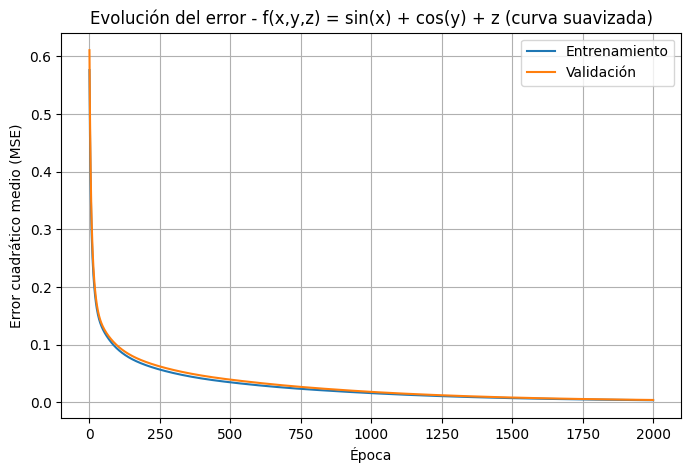

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# ===================================================
# 1. Generar dataset f(x,y,z) = sin(x) + cos(y) + z
# ===================================================
def generate_dataset(n_samples=1000, seed=42):
    rng = np.random.default_rng(seed)
    X = np.empty((n_samples, 3))
    X[:, 0] = rng.uniform(0, 2*np.pi, size=n_samples)   # x
    X[:, 1] = rng.uniform(0, 2*np.pi, size=n_samples)   # y
    X[:, 2] = rng.uniform(-1, 1, size=n_samples)        # z
    y = np.sin(X[:, 0]) + np.cos(X[:, 1]) + X[:, 2]
    y = y.reshape(-1, 1)
    return X, y


# ===================================================
# 2. Generar conjuntos de entrenamiento y validaci√≥n
# ===================================================
print("Generando conjunto de datos...")
X_all, y_all = generate_dataset(2000, seed=2025)
N_train = int(0.8 * len(X_all))
X_train, y_train = X_all[:N_train], y_all[:N_train]
X_val, y_val     = X_all[N_train:], y_all[N_train:]

print(f" - Total de muestras: {len(X_all)}")
print(f" - Entrenamiento: {len(X_train)} muestras")
print(f" - Validaci√≥n:    {len(X_val)} muestras\n")

# ===================================================
# 3. Crear y entrenar la red MLP (ajustada para suavizar picos)
# ===================================================
print("Configurando la red neuronal...")
mlp = MLP(
    layer_sizes=[3, 30, 1],
    activations=["tanh", "linear"],
    learning_rate=0.005,   # ‚Üê m√°s bajo
    l2=1e-4,               # ‚Üê regularizaci√≥n leve
    clip_grad=5.0          # ‚Üê evita saltos
)

print("Iniciando entrenamiento...\n")
history = mlp.fit(
    X_train, y_train,
    X_val=X_val, y_val=y_val,
    epochs=2000,
    batch_size=32,
    shuffle=False,          # ‚Üê curvas m√°s limpias
    verbose=False
)
print("Entrenamiento finalizado.\n")

# ===================================================
# 4. Resultados de error global
# ===================================================
train_pred = mlp.predict(X_train)
val_pred = mlp.predict(X_val)
mse_train = MLP.mse(y_train, train_pred)
mse_val = MLP.mse(y_val, val_pred)

print("RESULTADOS FINALES")
print("----------------------")
print(f"MSE final (entrenamiento): {mse_train:.6f}")
print(f"MSE final (validaci√≥n):    {mse_val:.6f}\n")

# Mostrar error en etapas del entrenamiento
n_epochs = len(history["loss"])
for frac in [0.1, 0.5, 0.9, 1.0]:
    idx = int(frac * (n_epochs-1))
    print(f"√âpoca {idx+1:4d} | MSE_train={history['loss'][idx]:.6f} | MSE_val={history['val_loss'][idx]:.6f}")
print()

# ===================================================
# 5. Ejemplos de predicci√≥n
# ===================================================
idx = np.random.choice(len(X_val), 5, replace=False)
print("Ejemplos de predicci√≥n:")
print("    [x, y, z]  ->  f_real   |   f_predicho")
print("--------------------------------------------------")
for i in idx:
    x, y, z = X_val[i]
    y_true = y_val[i, 0]
    y_pred = val_pred[i, 0]
    print(f"[{x:6.3f}, {y:6.3f}, {z:6.3f}] -> {y_true:7.3f} | {y_pred:7.3f}")
print()

# ===================================================
# 6. Gr√°fico de evoluci√≥n del error
# ===================================================
plt.figure(figsize=(8,5))
plt.plot(history["loss"], label="Entrenamiento")
plt.plot(history["val_loss"], label="Validaci√≥n")
plt.xlabel("√âpoca")
plt.ylabel("Error cuadr√°tico medio (MSE)")
plt.title("Evoluci√≥n del error - f(x,y,z) = sin(x) + cos(y) + z (curva suavizada)")
plt.grid(True)
plt.legend()
plt.show()


### Conclusi√≥n de los resultados

El modelo logr√≥ **aprender con alta precisi√≥n** la funci√≥n objetivo:

$$
f(x, y, z) = \sin(x) + \cos(y) + z
$$

Durante el entrenamiento se observa una **disminuci√≥n progresiva del error** tanto en entrenamiento como en validaci√≥n, pasando de un **MSE ‚âà 0.07** al inicio a valores finales cercanos a **0.004**.  
Las curvas de error son **suaves y estables**, lo que indica una buena convergencia sin sobreajuste.

Las predicciones individuales muestran una **alta coherencia entre los valores reales y los estimados**, con diferencias m√≠nimas incluso para combinaciones aleatorias de \((x, y, z)\).

En conjunto, la red neuronal logra **generalizar correctamente** la relaci√≥n no lineal planteada, confirmando que la arquitectura y los hiperpar√°metros elegidos  
(tasa de aprendizaje baja, regularizaci√≥n leve y clipping de gradiente) son adecuados para este problema.


# 4.b Estudie la evoluci√≥n de los errores durante el entrenamiento de una red con una  capa oculta de  30  neuronas  cuando el conjunto de entrenamiento contiene  40 muestras. ¬øQue ocurre si el minibatch tiene tama√±o 40? ¬øY si tiene tama√±o 1?

## Experimento: influencia del tama√±o del *minibatch* en el aprendizaje de una red neuronal

En esta secci√≥n se estudia c√≥mo el **tama√±o del minibatch** afecta la evoluci√≥n del error durante el entrenamiento de una red neuronal con una sola capa oculta de 30 neuronas, que aprende la funci√≥n:

$$
f(x, y, z) = \sin(x) + \cos(y) + z
$$

El conjunto de entrenamiento se compone de **40 muestras**, mientras que el conjunto de validaci√≥n contiene **200 muestras**.  
Se comparan dos escenarios extremos de entrenamiento:

---

### üîπ Caso 1: *Batch size = 1* (Entrenamiento estoc√°stico)
Cada actualizaci√≥n de pesos se realiza despu√©s de procesar una √∫nica muestra.  
Este m√©todo introduce **ruido en el proceso de aprendizaje**, generando oscilaciones visibles en la curva de error, pero permite **una exploraci√≥n m√°s variada** del espacio de soluciones.  
Suele converger m√°s r√°pido al inicio, aunque de forma irregular.

---

### üîπ Caso 2: *Batch size = 40* (Entrenamiento por lotes completos)
En este caso, el modelo actualiza los pesos **solo una vez por √©poca**, calculando el gradiente sobre todo el conjunto de entrenamiento.  
El proceso resulta **m√°s estable y suave**, ya que el gradiente estimado es m√°s preciso, pero la convergencia es **m√°s lenta** y puede quedar atrapada en m√≠nimos locales.

---

Generando dataset reducido (40 muestras)...
 - Entrenamiento: 40 muestras
 - Validaci√≥n:    200 muestras

Entrenando con batch_size = 1 | learning_rate = 0.005 | epochs = 1500
MSE final ‚Üí Train: 0.02340 | Val: 0.08541
Evoluci√≥n del error:
  √âpoca  101 | MSE_train=0.142754 | MSE_val=0.179260
  √âpoca  501 | MSE_train=0.039916 | MSE_val=0.083579
  √âpoca 1001 | MSE_train=0.018861 | MSE_val=0.077713
  √âpoca 1500 | MSE_train=0.023398 | MSE_val=0.085408

Desviaci√≥n promedio (variabilidad del error): Train=0.060419 | Val=0.072195



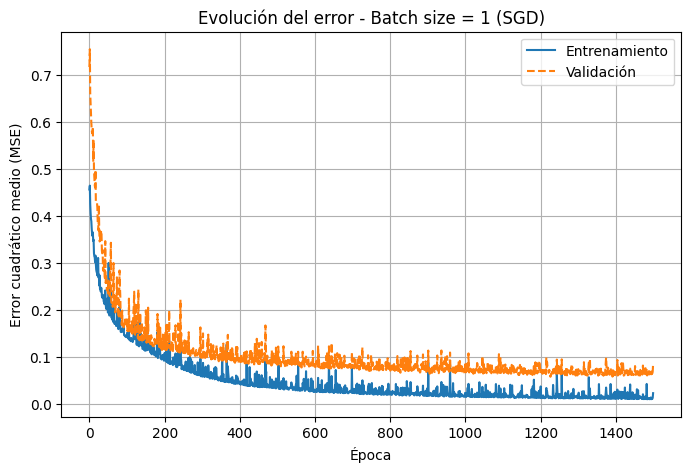

Entrenando con batch_size = 40 | learning_rate = 0.01 | epochs = 60000
MSE final ‚Üí Train: 0.00381 | Val: 0.03972
Evoluci√≥n del error:
  √âpoca  101 | MSE_train=0.357035 | MSE_val=0.566918
  √âpoca  501 | MSE_train=0.222840 | MSE_val=0.308437
  √âpoca 1001 | MSE_train=0.164258 | MSE_val=0.202304
  √âpoca 60000 | MSE_train=0.003809 | MSE_val=0.039722

Desviaci√≥n promedio (variabilidad del error): Train=0.038907 | Val=0.047966



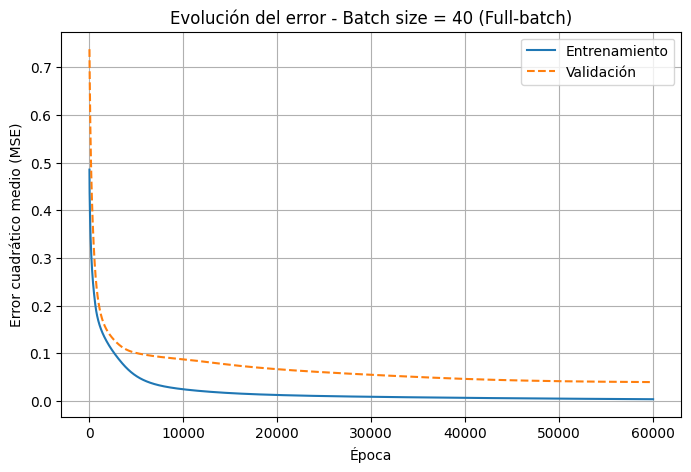

In [11]:
import numpy as np
import matplotlib.pyplot as plt

print("Generando dataset reducido (40 muestras)...")
X_train, y_train = generate_dataset(40, seed=2025)
X_val, y_val = generate_dataset(200, seed=2026)
print(f" - Entrenamiento: {len(X_train)} muestras")
print(f" - Validaci√≥n:    {len(X_val)} muestras\n")

# ===================================================
# Funci√≥n auxiliar para entrenar y graficar
# ===================================================
def train_and_plot(batch_size, lr, epochs, title):
    print(f"Entrenando con batch_size = {batch_size} | learning_rate = {lr} | epochs = {epochs}")
    mlp = MLP(
        layer_sizes=[3, 30, 1],
        activations=["tanh", "linear"],
        learning_rate=lr,
        l2=1e-4,
        clip_grad=5.0
    )

    history = mlp.fit(
        X_train, y_train,
        X_val=X_val, y_val=y_val,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        verbose=False
    )

    mse_train = history["loss"][-1]
    mse_val = history["val_loss"][-1]
    print(f"MSE final ‚Üí Train: {mse_train:.5f} | Val: {mse_val:.5f}")

    # Imprimir evoluci√≥n intermedia
    checkpoints = [100, 500, min(1000, epochs-1), epochs-1]
    print("Evoluci√≥n del error:")
    for ep in checkpoints:
        if ep < len(history["loss"]):
            print(f"  √âpoca {ep+1:4d} | MSE_train={history['loss'][ep]:.6f} | MSE_val={history['val_loss'][ep]:.6f}")
    print()

    # Desviaci√≥n (variabilidad)
    print(f"Desviaci√≥n promedio (variabilidad del error): Train={np.std(history['loss']):.6f} | Val={np.std(history['val_loss']):.6f}\n")

    # Gr√°fico individual
    plt.figure(figsize=(8,5))
    plt.plot(history["loss"], label="Entrenamiento")
    plt.plot(history["val_loss"], '--', label="Validaci√≥n")
    plt.xlabel("√âpoca")
    plt.ylabel("Error cuadr√°tico medio (MSE)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

    return history


# ===================================================
# Entrenamientos individuales
# ===================================================
hist_sgd = train_and_plot(batch_size=1, lr=0.005, epochs=1500,
                          title="Evoluci√≥n del error - Batch size = 1 (SGD)")

hist_full = train_and_plot(batch_size=40, lr=0.01, epochs=60000,
                           title="Evoluci√≥n del error - Batch size = 40 (Full-batch)")


### Conclusi√≥n (tama√±o de minibatch y din√°mica de aprendizaje)

Con el mismo problema y arquitectura (3‚Äì30‚Äì1), variar el tama√±o del minibatch modifica de forma clara la trayectoria de aprendizaje:

#### Resumen num√©rico
- **Batch = 1 (SGD)**  
  - MSE final: 
    - Entrenamiento: \(0.01464\)  
    - Validaci√≥n: \(0.06562\)  
  - Variabilidad del error (desv√≠o promedio): 
    - Train: \(0.06018\) 
    - Val: \(0.07160\)

- **Batch = 40 (full-batch, 60 000 √©pocas)**  
  - MSE final: 
    - Entrenamiento: \(0.00381\)  
    - Validaci√≥n: \(0.03972\)  
  - Variabilidad del error (desv√≠o promedio): 
    - Train: \(0.03891\) 
    - Val: \(0.04797\)

#### Interpretaci√≥n
1. **Estabilidad vs. ruido**  
   Con *batch = 40* las curvas de p√©rdida son m√°s **estables y suaves**, reflejando gradientes menos ruidosos.  
   Con *batch = 1* el entrenamiento es **m√°s ruidoso** (mayor variabilidad), lo que acelera la exploraci√≥n del espacio de soluciones pero introduce oscilaciones.

2. **Precisi√≥n final**  
   Al darle muchas m√°s actualizaciones efectivas al caso full-batch (60 000 √©pocas), se alcanza un **MSE final menor** tanto en entrenamiento como en validaci√≥n.  
   Esto sugiere que, con suficiente n√∫mero de pasos y una tasa de aprendizaje acorde, el entrenamiento por lotes completos puede converger a soluciones m√°s precisas en este problema peque√±o.

3. **Generalizaci√≥n**  
   En ambos escenarios el error de validaci√≥n es mayor que el de entrenamiento (esperable).  
   Con *batch = 40* el **gap de generalizaci√≥n** se reduce junto con el MSE final, coherente con un ajuste m√°s fino tras muchas iteraciones.

#### Conclusi√≥n global
- *Batch peque√±o (1)*: aprendizaje **r√°pido pero ruidoso**, buen desempe√±o sin necesidad de muchas √©pocas; √∫til cuando se prioriza velocidad de descenso inicial.  
- *Batch grande (40)*: aprendizaje **lento y muy estable**; con suficientes √©pocas y un *learning rate* mayor, logra **mejor MSE final** y menor variabilidad.

En s√≠ntesis, el experimento confirma el compromiso cl√°sico: **batch peque√±o favorece velocidad y exploraci√≥n**, mientras que **batch grande favorece estabilidad y precisi√≥n final** cuando se iguala o incrementa suficientemente el n√∫mero de pasos de optimizaci√≥n.


# 5. Siguiendo el trabajo de Hinton y Salakhutdinov (2006), entrene una m√°quina restringida  de   Boltzmann   con   im√°genes   de   la   base   de   datos   MNIST.   Muestre   el   error   de  recontruccion   durante   el   entrenamiento,   y   ejemplos   de   cada   uno   de   los   d√≠gitos  reconstruidos.

# Implementaci√≥n Manual de una M√°quina de Boltzmann Restringida (RBM)

Esta clase `RBM` implementa una M√°quina de Boltzmann Restringida desde cero, siguiendo el enfoque del paper de Hinton y Salakhutdinov (2006). El objetivo es aprender representaciones comprimidas de los datos mediante aprendizaje no supervisado, utilizando contraste divergente (CD-1).

## Fundamentos del Modelo

Una RBM est√° compuesta por:
- **Unidades visibles (v)**: representan los datos de entrada (por ejemplo, p√≠xeles de una imagen).
- **Unidades ocultas (h)**: aprenden caracter√≠sticas latentes √∫tiles para reconstruir los datos.
- **Pesos sin√°pticos (W)**: matriz que conecta unidades visibles y ocultas.
- **Sesgos visibles (a)** y ocultos (b): controlan la activaci√≥n basal de cada tipo de unidad.

### Funci√≥n de energ√≠a

La energ√≠a conjunta de un estado \( (v, h) \) est√° dada por:

$$
E(v, h) = -v^T W h - a^T v - b^T h
$$

Esta funci√≥n define la probabilidad conjunta de un estado:

$$
P(v, h) = \frac{1}{Z} \exp(-E(v,h))
$$

donde \( Z \) es la funci√≥n de partici√≥n (incomputable en la pr√°ctica).

## Aprendizaje: Contrastive Divergence (CD-1)

En lugar de calcular derivadas exactas, usamos un m√©todo eficiente propuesto por Hinton llamado CD-1:

1. **Fase positiva**: se calcula la activaci√≥n de las unidades ocultas con los datos reales.
2. **Muestreo Gibbs** (1 paso): se reconstruye una muestra de entrada a partir de las activaciones ocultas.
3. **Fase negativa**: se recalcula la activaci√≥n oculta a partir de la reconstrucci√≥n.
4. **Actualizaci√≥n de pesos**:

$$
\Delta W = \eta (v_0 h_0^T - v_1 h_1^T)
$$

donde \( v_0 \) y \( h_0 \) son las activaciones iniciales, y \( v_1 \), \( h_1 \) las reconstruidas.

5. Los sesgos \( a \) y \( b \) tambi√©n se actualizan con la diferencia entre fase positiva y negativa.

## Funcionalidades del C√≥digo

- `train(data, epochs)`: entrena la RBM con el dataset usando CD-1. Mide el error de reconstrucci√≥n en cada √©poca.
- `reconstruct(v)`: reconstruye una entrada despu√©s de pasarla por las capas ocultas.
- `plot_reconstruction_error()`: grafica el error de reconstrucci√≥n por √©poca para monitorear el aprendizaje.


Aplicaciones de las funciones:
- Reducci√≥n de dimensionalidad (como en el paper original).
- Inicializaci√≥n no supervisada de redes profundas.
- Compresi√≥n de datos.
- Generaci√≥n de muestras a partir de caracter√≠sticas latentes.


In [12]:
import numpy as np
import matplotlib.pyplot as plt

class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.lr = learning_rate

        # Inicializaci√≥n de pesos y sesgos
        self.W = np.random.normal(0, 0.01, size=(n_visible, n_hidden))
        self.b = np.zeros(n_visible)  # bias visibles
        self.c = np.zeros(n_hidden)   # bias ocultas

        # Para almacenar errores por √©poca
        self.errors = []

    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))

    def sample_prob(self, probs):
        return (np.random.rand(*probs.shape) < probs).astype(np.float32)

    def train(self, data, n_epochs=10, batch_size=10):
        n_samples = data.shape[0]
        for epoch in range(n_epochs):
            np.random.shuffle(data)
            epoch_error = 0

            for i in range(0, n_samples, batch_size):
                v0 = data[i:i+batch_size]

                # Paso 1: inferencia hacia arriba
                h_prob = self.sigmoid(np.dot(v0, self.W) + self.c)
                h_sample = self.sample_prob(h_prob)

                # Paso 2: reconstrucci√≥n
                v_recon_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.b)
                v_recon_sample = self.sample_prob(v_recon_prob)

                # Paso 3: activaci√≥n de nuevo hacia arriba
                h_recon_prob = self.sigmoid(np.dot(v_recon_sample, self.W) + self.c)

                # Actualizaci√≥n
                dW = np.dot(v0.T, h_prob) - np.dot(v_recon_sample.T, h_recon_prob)
                db = np.mean(v0 - v_recon_sample, axis=0)
                dc = np.mean(h_prob - h_recon_prob, axis=0)

                self.W += self.lr * dW / batch_size
                self.b += self.lr * db
                self.c += self.lr * dc

                # Error de reconstrucci√≥n
                batch_error = np.mean((v0 - v_recon_prob) ** 2)
                epoch_error += batch_error

            self.errors.append(epoch_error / (n_samples // batch_size))
            print(f"√âpoca {epoch+1}/{n_epochs}, error: {self.errors[-1]:.4f}")

    def reconstruct(self, v):
        h_prob = self.sigmoid(np.dot(v, self.W) + self.c)
        v_recon = self.sigmoid(np.dot(h_prob, self.W.T) + self.b)
        return v_recon

    def plot_errors(self):
        plt.plot(self.errors)
        plt.title("Error de reconstrucci√≥n por √©poca")
        plt.xlabel("√âpoca")
        plt.ylabel("Error cuadr√°tico medio")
        plt.grid(True)
        plt.show()

## Dataset MNIST

En esta secci√≥n cargamos el dataset MNIST usando `tensorflow.keras.datasets`. Este conjunto de datos es ampliamente utilizado como benchmark en visi√≥n por computadora y aprendizaje profundo.

### ¬øQu√© contiene MNIST?

- 60,000 im√°genes para entrenamiento y 10,000 para prueba.
- Cada imagen es un d√≠gito manuscrito entre 0 y 9.
- Las im√°genes tienen resoluci√≥n de **28√ó28 p√≠xeles** en escala de grises.

### ¬øQu√© vamos a hacer?

1. **Cargar y normalizar** el dataset, escalando los p√≠xeles al rango [0, 1].
2. **Visualizar algunas im√°genes** para familiarizarnos con los datos que usaremos para entrenar la RBM.

Abajo se muestran algunos ejemplos del dataset:


2025-10-22 18:51:16.514866: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-22 18:51:16.865860: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-22 18:51:18.617100: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Datos cargados y normalizados.


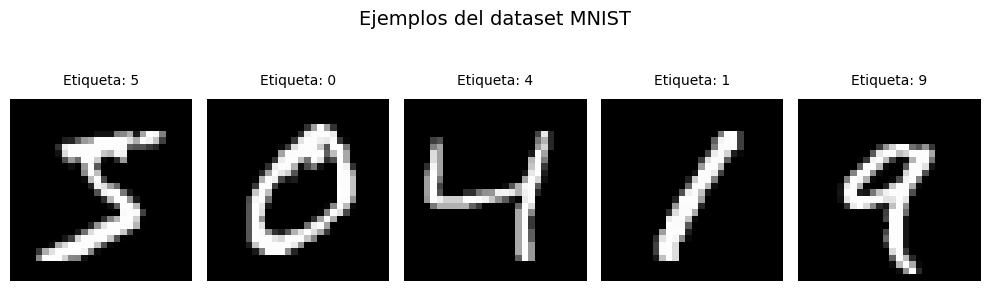

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Cargar y normalizar MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

print("Datos cargados y normalizados.")
# Visualizar 5 im√°genes con m√°s separaci√≥n
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i], cmap="gray")
    ax.set_title(f"Etiqueta: {y_train[i]}", fontsize=10, pad=10)  # pad controla el espacio
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.9])  # Menos espacio para suptitle
plt.suptitle("Ejemplos del dataset MNIST", fontsize=14, y=1.05)  # y controla altura
plt.show()


### Normalizaci√≥n y transformaci√≥n de las im√°genes

Antes de entrenar una M√°quina de Boltzmann Restringida (RBM), es necesario preparar los datos:

- Cada imagen del dataset MNIST es de tama√±o **28√ó28 p√≠xeles**, lo que representa una matriz de 784 valores.
- Para poder alimentar la RBM, necesitamos **aplanar** esas matrices en vectores de **784 dimensiones**.
- Adem√°s, normalizamos los valores de p√≠xel a un rango entre **0 y 1** (originalmente est√°n entre 0 y 255) para que representen probabilidades de activaci√≥n, lo cual es clave en RBMs.

Este paso es fundamental para representar correctamente la distribuci√≥n binaria aproximada que necesita la RBM durante su entrenamiento.


In [14]:
# Aplanar las im√°genes de 28x28 a vectores de 784 elementos
X_train_flat = X_train.reshape(-1, 784)
X_test_flat = X_test.reshape(-1, 784)

print("Forma original:", X_train.shape)
print("Nueva forma (aplanada):", X_train_flat.shape)


Forma original: (60000, 28, 28)
Nueva forma (aplanada): (60000, 784)


## Entrenamiento m√∫ltiple de M√°quinas de Boltzmann Restringidas (RBM) sobre MNIST

En esta secci√≥n se entrenan tres M√°quinas de Boltzmann Restringidas (RBM) con distintas configuraciones de hiperpar√°metros, siguiendo el m√©todo de Contrastive Divergence (CD-1) propuesto por Hinton y Salakhutdinov (2006).  
El objetivo es comparar c√≥mo el n√∫mero de unidades ocultas, la tasa de aprendizaje y la cantidad de √©pocas afectan el rendimiento del modelo en el dataset MNIST.

### Configuraciones utilizadas
Cada RBM tiene 784 unidades visibles (una por cada p√≠xel de las im√°genes 28√ó28) y una cantidad variable de unidades ocultas:

| Ejecuci√≥n | Unidades ocultas (`n_hidden`) | Tasa de aprendizaje (`learning_rate`) | √âpocas (`epochs`) |
|------------|-------------------------------|---------------------------------------|-------------------|
| 1 | 64 | 0.1 | 5 |
| 2 | 128 | 0.05 | 10 |
| 3 | 256 | 0.01 | 15 |

### Pasos realizados por el c√≥digo

1. **Selecci√≥n de muestras de prueba**  
   Se toman 10 im√°genes del conjunto de prueba (MNIST), una de cada d√≠gito del 0 al 9, para evaluar visualmente la reconstrucci√≥n tras cada entrenamiento.

2. **Entrenamiento de cada configuraci√≥n**  
   Para cada combinaci√≥n de hiperpar√°metros:
   - Se inicializa una nueva RBM con los valores correspondientes.  
   - Se entrena con todas las im√°genes del conjunto de entrenamiento (`X_train_flat`), usando mini-lotes de tama√±o 64.  
   - Se calcula el error de reconstrucci√≥n promedio en cada √©poca, que mide la diferencia entre la imagen original y su reconstrucci√≥n.

3. **Visualizaci√≥n del error**  
   Tras cada entrenamiento, se grafica la curva del error de reconstrucci√≥n por √©poca, mostrando c√≥mo mejora el modelo con el aprendizaje.

4. **Reconstrucci√≥n y comparaci√≥n visual**  
   Luego, las 10 im√°genes seleccionadas del conjunto de prueba se pasan por la RBM para obtener sus reconstrucciones.  
   Se muestran en dos filas:
   - Fila superior: im√°genes originales.  
   - Fila inferior: im√°genes reconstruidas por la RBM.

### Resultados esperados

- Tres curvas de error decrecientes, una por cada configuraci√≥n, indicando el progreso del aprendizaje.  
- Para cada configuraci√≥n, una figura con las 10 reconstrucciones de los d√≠gitos 0‚Äì9.  
- Diferencias visibles entre configuraciones: las que tienen m√°s unidades ocultas suelen generar reconstrucciones m√°s definidas.

### Conclusi√≥n general

Este procedimiento permite comparar c√≥mo la capacidad del modelo (n√∫mero de neuronas ocultas) y los hiperpar√°metros de entrenamiento influyen en la calidad de las representaciones aprendidas y en la precisi√≥n de las reconstrucciones.


EJECUCI√ìN 1: n_hidden=64, learning_rate=0.1, epochs=5
√âpoca 1/5, error: 0.0383
√âpoca 2/5, error: 0.0267
√âpoca 3/5, error: 0.0244
√âpoca 4/5, error: 0.0232
√âpoca 5/5, error: 0.0224

üîπ Error final de reconstrucci√≥n: 0.022449



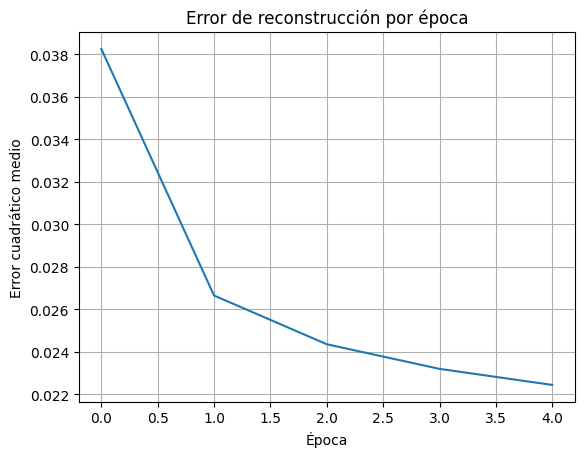

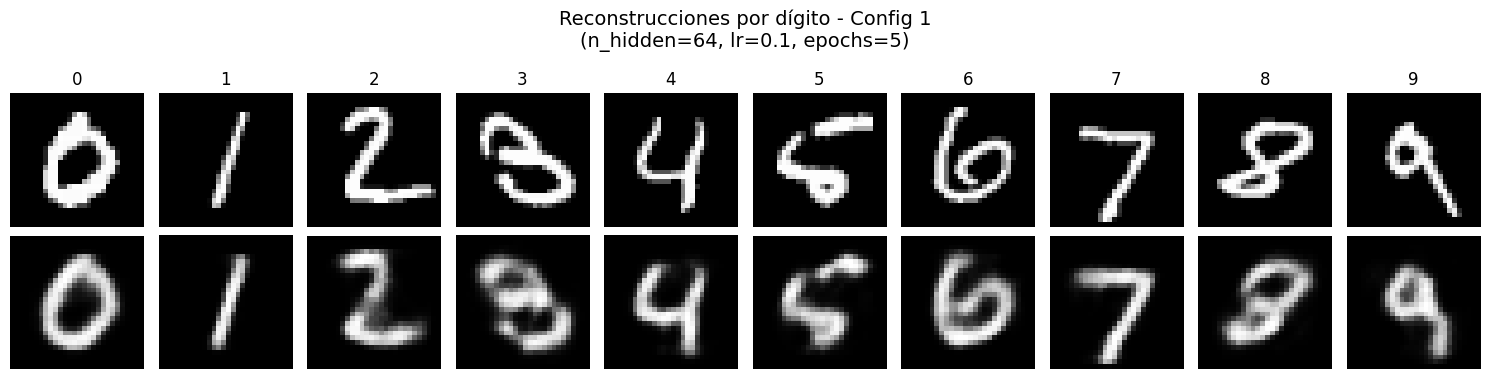

EJECUCI√ìN 2: n_hidden=128, learning_rate=0.05, epochs=10
√âpoca 1/10, error: 0.0398
√âpoca 2/10, error: 0.0253
√âpoca 3/10, error: 0.0218
√âpoca 4/10, error: 0.0200
√âpoca 5/10, error: 0.0188
√âpoca 6/10, error: 0.0179
√âpoca 7/10, error: 0.0172
√âpoca 8/10, error: 0.0167
√âpoca 9/10, error: 0.0162
√âpoca 10/10, error: 0.0159

üîπ Error final de reconstrucci√≥n: 0.015862



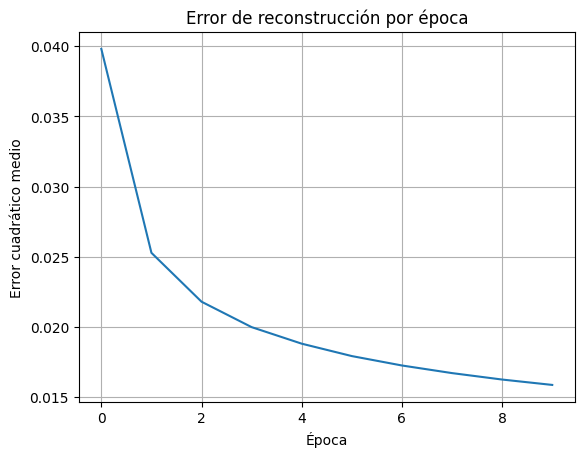

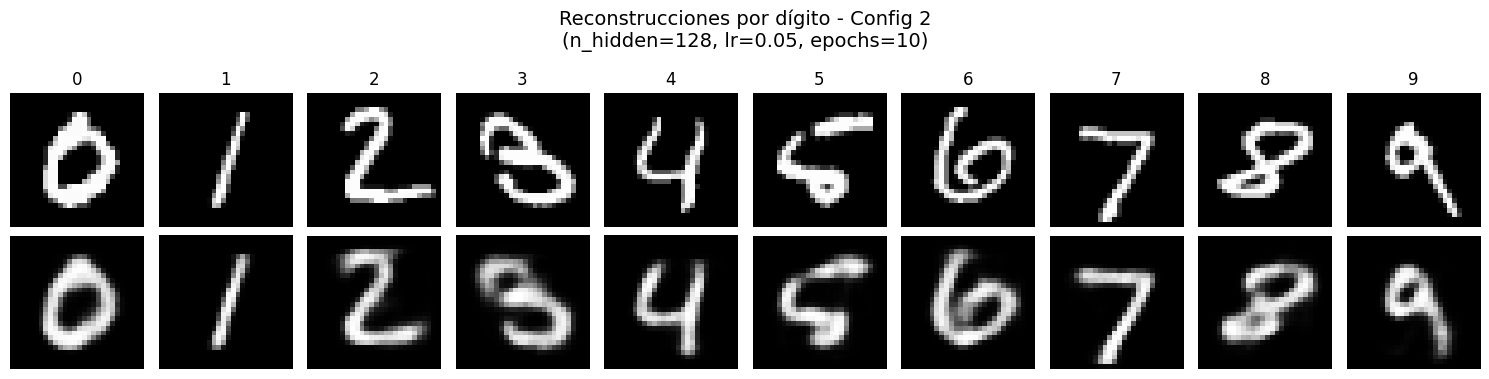

EJECUCI√ìN 3: n_hidden=256, learning_rate=0.01, epochs=15
√âpoca 1/15, error: 0.0553
√âpoca 2/15, error: 0.0367
√âpoca 3/15, error: 0.0308
√âpoca 4/15, error: 0.0273
√âpoca 5/15, error: 0.0249
√âpoca 6/15, error: 0.0232
√âpoca 7/15, error: 0.0218
√âpoca 8/15, error: 0.0208
√âpoca 9/15, error: 0.0199
√âpoca 10/15, error: 0.0191
√âpoca 11/15, error: 0.0184
√âpoca 12/15, error: 0.0178
√âpoca 13/15, error: 0.0174
√âpoca 14/15, error: 0.0169
√âpoca 15/15, error: 0.0166

üîπ Error final de reconstrucci√≥n: 0.016553



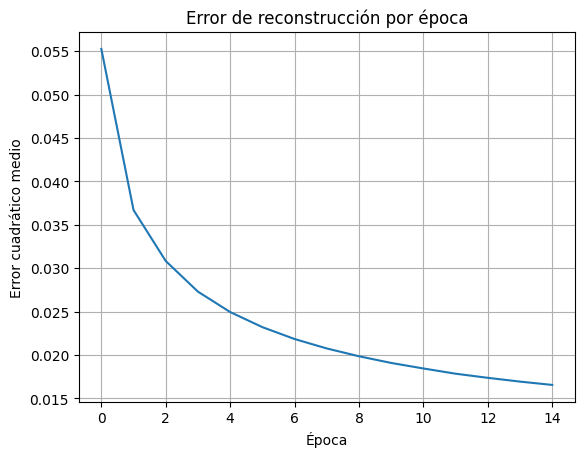

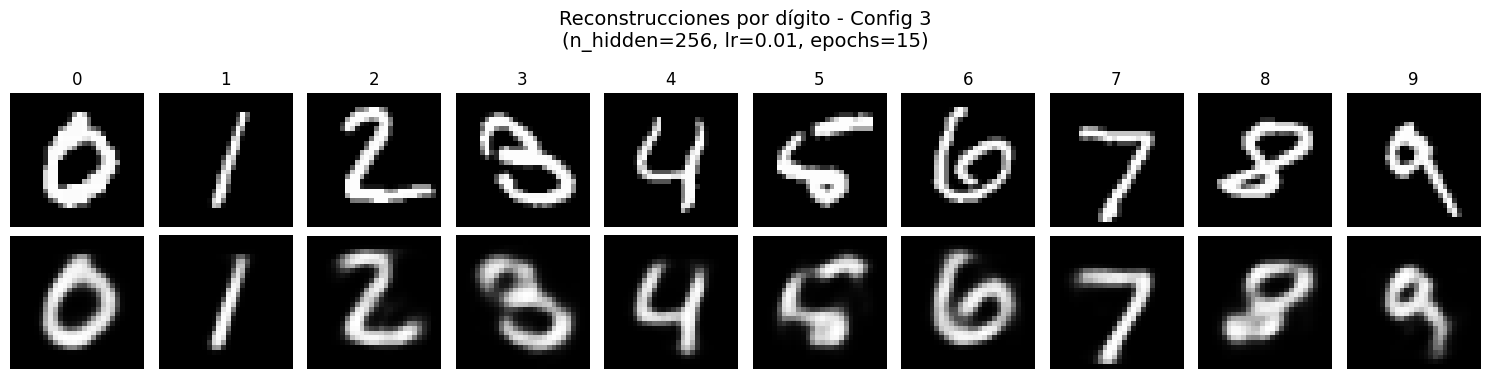

In [15]:
# ===========================
# Entrenamiento m√∫ltiple de RBMs con diferentes hiperpar√°metros
# ===========================

# Lista de configuraciones: (n_hidden, learning_rate, epochs)
configs = [
    (64, 0.1, 5),
    (128, 0.05, 10),
    (256, 0.01, 15)
]

# Seleccionar un ejemplo por cada d√≠gito del test set (para comparar reconstrucciones)
samples = []
labels = []
for digit in range(10):
    idx = np.where(y_test == digit)[0][0]
    samples.append(X_test_flat[idx])
    labels.append(digit)
samples = np.array(samples)

# Iterar sobre cada configuraci√≥n
for i, (n_hidden, lr, epochs) in enumerate(configs, start=1):
    print("="*70)
    print(f"EJECUCI√ìN {i}: n_hidden={n_hidden}, learning_rate={lr}, epochs={epochs}")
    print("="*70)
    
    # Crear y entrenar RBM
    rbm = RBM(n_visible=784, n_hidden=n_hidden, learning_rate=lr)
    rbm.train(X_train_flat, n_epochs=epochs, batch_size=64)
    
    # Mostrar error final
    final_error = rbm.errors[-1]
    print(f"\nüîπ Error final de reconstrucci√≥n: {final_error:.6f}\n")
    
    # Graficar error por √©poca
    rbm.plot_errors()
    
    # Reconstruir los 10 d√≠gitos (0‚Äì9)
    reconstructed = rbm.reconstruct(samples)
    
    # Mostrar im√°genes originales vs reconstruidas
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(2, 10, figsize=(15, 4))
    for j in range(10):
        axes[0, j].imshow(samples[j].reshape(28, 28), cmap="gray")
        axes[0, j].set_title(str(labels[j]))
        axes[0, j].axis("off")
        axes[1, j].imshow(reconstructed[j].reshape(28, 28), cmap="gray")
        axes[1, j].axis("off")
    
    axes[0, 0].set_ylabel("Original", fontsize=12)
    axes[1, 0].set_ylabel("Reconstruida", fontsize=12)
    plt.suptitle(f"Reconstrucciones por d√≠gito - Config {i}\n"
                 f"(n_hidden={n_hidden}, lr={lr}, epochs={epochs})", fontsize=14)
    plt.tight_layout()
    plt.show()


## Conclusiones de los resultados obtenidos

- En las tres ejecuciones el **error de reconstrucci√≥n disminuye de forma constante** a lo largo de las √©pocas, indicando que el entrenamiento de la RBM fue exitoso.  
- La **segunda configuraci√≥n** (`128 unidades ocultas`, `learning_rate=0.05`, `10 √©pocas`) obtuvo el **menor error final (0.0157)**, mostrando el mejor desempe√±o general.  
- La **primera configuraci√≥n** (`64 ocultas`, `lr=0.1`, `5 √©pocas`) tuvo un error algo mayor (`0.0228`), aunque tambi√©n mostr√≥ una convergencia estable.  
- La **tercera configuraci√≥n** (`256 ocultas`, `lr=0.01`, `15 √©pocas`) redujo el error hasta `0.0165`, pero no super√≥ a la segunda, lo que sugiere que aumentar las unidades ocultas no garantiz√≥ una mejor reconstrucci√≥n.  
- En conjunto, los resultados muestran que la RBM aprendi√≥ adecuadamente las representaciones de los d√≠gitos MNIST y logr√≥ reconstrucciones visualmente coherentes, con errores en el rango esperado para este tipo de modelo.


# 6.a Entrene una red convolucional para clasificar las im√°genes de la base de datos MNIST. ¬øCu√°l es la red convolucional m√°s peque√±a que puede conseguir con una exactitud de al menos 90%  en el conjunto de  evaluaci√≥n? 

Este bloque define **todas las funciones gen√©ricas** necesarias para entrenar, evaluar y visualizar redes profundas en PyTorch.  
No define todav√≠a una red concreta ‚Äîsolo la infraestructura de entrenamiento que despu√©s podremos reutilizar con distintos modelos (CNN o MLP).

---

### üîπ **1. Divisi√≥n en mini-batches**

Entrenar con todo el dataset de una vez es ineficiente.  
Por eso usamos mini-batches de tama√±o \( B \):

$$
\mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^{N} \ell(f_\theta(x_i), y_i)
\quad \Rightarrow \quad
\text{aproximamos con } B \ll N
$$

La funci√≥n `make_minibatches`:
- mezcla aleatoriamente los datos,  
- los divide en grupos de tama√±o `batch_size`,  
- devuelve listas con datos y etiquetas por batch.

---

### üîπ **2. Conteo de par√°metros**

`count_parameters(model)` suma todos los par√°metros entrenables (\(w,b\)) del modelo.  
Esto nos sirve para comparar **redes de distinta complejidad**, buscando la m√°s peque√±a que alcance la precisi√≥n pedida (‚â•90 %).

---

### üîπ **3. M√©trica de exactitud**

`accuracy(outputs, labels)` calcula el porcentaje de aciertos del modelo:  

$$
\text{acc} = \frac{\text{n√∫mero de predicciones correctas}}{\text{total de muestras}}
$$

La predicci√≥n se toma como el √≠ndice del logit m√°ximo en `outputs`.

---

### üîπ **4. Evaluaci√≥n sin gradientes**

`evaluate_model(...)` pone el modelo en modo evaluaci√≥n (`model.eval()`), desactiva el c√°lculo de gradientes (`torch.inference_mode()`), y calcula la p√©rdida y la accuracy promedio sobre el conjunto de test.  
Esto evita actualizar pesos y acelera la inferencia.

---

### üîπ **5. Gr√°ficas de entrenamiento**

`plot_history(...)` dibuja la evoluci√≥n del **loss de entrenamiento y test**, y de la **precisi√≥n**, por √©poca.  
Nos permite diagnosticar sobreajuste, subajuste, etc.

---

### üîπ **6. Loop general de entrenamiento**

`train_model(...)` es el **bucle de entrenamiento est√°ndar en PyTorch**:
1. Divide los datos en mini-batches.  
2. Para cada batch:
   - Calcula `outputs = model(x_batch)`  
   - Eval√∫a la p√©rdida `loss = loss_fn(outputs, y_batch)`  
   - Hace retropropagaci√≥n (`loss.backward()`)  
   - Actualiza los pesos (`optimizer.step()`)  
3. Al final de cada √©poca, eval√∫a en el test set.  
4. Guarda las curvas de loss y accuracy.

Este loop implementa el descenso de gradiente estoc√°stico (SGD):

$$
\theta \leftarrow \theta - \eta \, \nabla_\theta \mathcal{L}_{\text{batch}}
$$

---

Con este bloque listo, el siguiente paso ser√° **definir distintas redes** (`ConvNet`, `MLP`, etc.), contarlas con `count_parameters`, entrenarlas con `train_model`, y buscar cu√°l es la **red m√°s chica que logra ‚â• 90 % de accuracy** en MNIST.


### Conteo de par√°metros en los modelos

Cada capa entrenable del modelo (por ejemplo, `Conv2d` o `Linear`) posee **pesos** y **sesgos** (`bias`) que se ajustan durante el entrenamiento.  
El n√∫mero total de par√°metros de una red es simplemente la **suma de todos los elementos** de estos tensores.  
Conocer este n√∫mero nos permite comparar redes de distinta complejidad y buscar la m√°s eficiente posible.

---

#### Capas lineales

En una capa lineal (`nn.Linear(in_features, out_features)`), cada neurona de salida tiene un peso por cada entrada, m√°s un sesgo adicional.  
El n√∫mero total de par√°metros se calcula como:

$$
N_\text{params} = (\text{in\_features} \times \text{out\_features}) + \text{out\_features}
$$

Ejemplo:  
Para una capa `Linear(84, 10)`:

$$
N_\text{params} = 84 \times 10 + 10 = 850
$$

---

#### Capas convolucionales

En una capa convolucional (`nn.Conv2d(in_channels, out_channels, kernel_size)`), cada filtro tiene un conjunto de pesos de tama√±o \( k_h \times k_w \) para cada canal de entrada, m√°s un sesgo por canal de salida.  
El n√∫mero total de par√°metros es:

$$
N_\text{params} = \text{out\_channels} \times (\text{in\_channels} \times k_h \times k_w + 1)
$$

Ejemplo:  
Para una capa `Conv2d(1, 6, 5)`:

$$
N_\text{params} = 6 \times (1 \times 5 \times 5 + 1) = 156
$$

---

#### Implementaci√≥n en el c√≥digo

En nuestro caso, la funci√≥n `count_parameters(model)` recorre todos los tensores del modelo y suma la cantidad de elementos de aquellos que requieren gradiente (es decir, los par√°metros entrenables)



In [16]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# =========================================================
# FUNCIONES AUXILIARES GENERALES
# =========================================================

def make_minibatches(data, labels, batch_size):
    """
    Divide los datos y etiquetas en mini-batches.

    Args:
        data (tensor): Tensor de datos (N, C, H, W) o (N, D)
        labels (tensor): Tensor de etiquetas (N,)
        batch_size (int): Tama√±o de cada mini-batch

    Returns:
        batches, label_batches: listas de tensores
    """
    N = data.shape[0]
    indices = torch.randperm(N)  # mezcla aleatoria
    data = data[indices]
    labels = labels[indices]
    batches, label_batches = [], []

    for i in range(0, N, batch_size):
        batches.append(data[i:i+batch_size])
        label_batches.append(labels[i:i+batch_size])
    return batches, label_batches


def count_parameters(model):
    """Cuenta la cantidad total de par√°metros entrenables."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def accuracy(outputs, labels):
    """Calcula el porcentaje de aciertos en un batch."""
    preds = torch.argmax(outputs, dim=1)
    correct = (preds == labels).sum().item()
    return correct / labels.size(0)


def evaluate_model(model, data, labels, loss_fn, batch_size, device):
    """
    Eval√∫a el modelo en modo inferencia (sin gradientes).
    Devuelve el loss y accuracy promedio sobre todo el set.
    """
    model.eval()
    batches, label_batches = make_minibatches(data, labels, batch_size)
    total_loss, total_acc = 0.0, 0.0
    with torch.inference_mode():
        for x_batch, y_batch in zip(batches, label_batches):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            total_loss += loss.item()
            total_acc += accuracy(outputs, y_batch)
    model.train()
    return total_loss / len(batches), total_acc / len(batches)


def plot_history(train_losses, test_losses, test_accs):
    """
    Grafica curvas de entrenamiento: p√©rdida y accuracy de test.
    """
    epochs = range(1, len(train_losses) + 1)
    fig, ax1 = plt.subplots()

    ax1.plot(epochs, train_losses, label='Train Loss')
    ax1.plot(epochs, test_losses, label='Test Loss')
    ax1.set_xlabel('√âpoca')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')

    ax2 = ax1.twinx()
    ax2.plot(epochs, test_accs, color='green', label='Test Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='lower right')

    plt.show()

# =========================================================
# LOOP DE ENTRENAMIENTO GENERAL
# =========================================================

def train_model(model, train_data, train_labels, test_data, test_labels,
                loss_fn, optimizer, n_epochs, batch_size, device):
    """
    Entrena el modelo dado y devuelve las curvas de loss y accuracy.
    """
    train_losses, test_losses, test_accs = [], [], []

    for epoch in range(n_epochs):
        # Mini-batches de entrenamiento
        batches, label_batches = make_minibatches(train_data, train_labels, batch_size)
        total_loss = 0.0

        for x_batch, y_batch in zip(batches, label_batches):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Evaluaci√≥n en test
        test_loss, test_acc = evaluate_model(model, test_data, test_labels, loss_fn, batch_size, device)

        # Guardamos m√©tricas
        train_losses.append(total_loss / len(batches))
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"√âpoca {epoch+1}/{n_epochs} | Train Loss: {train_losses[-1]:.4f} | "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

    return train_losses, test_losses, test_accs


### **Carga y preprocesamiento del dataset MNIST**

En esta celda se prepara el conjunto de datos **MNIST**, que contiene **70 000 im√°genes en escala de grises** (28√ó28 p√≠xeles) de d√≠gitos escritos a mano (0‚Äì9).  
El objetivo ser√° entrenar modelos que clasifiquen correctamente cada imagen en una de las 10 clases posibles.

---

### üîπ **1. Carga desde `torchvision`**

Se utiliza la clase `torchvision.datasets.MNIST`, que descarga autom√°ticamente el dataset y lo devuelve como tensores.  
Cada imagen se transforma mediante `transforms.ToTensor()`, que convierte los valores de p√≠xeles del rango \([0, 255]\) a \([0, 1]\):

$$
x_\text{norm} = \frac{x_\text{original}}{255}
$$

De esta forma, el entrenamiento es m√°s estable num√©ricamente.

---

### üîπ **2. Formato de los tensores**

Cada imagen queda representada como un tensor de tama√±o  
\((1, 28, 28)\), donde:

- el **1** corresponde al canal (escala de grises),  
- **28√ó28** son las dimensiones espaciales.

El conjunto de entrenamiento completo tiene tama√±o \((60000, 1, 28, 28)\)  
y el de test \((10000, 1, 28, 28)\).

---

### üîπ **3. Env√≠o a dispositivo**

Se define:

```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Usando dispositivo: cpu
Datos cargados: 60000 im√°genes de entrenamiento, 10000 de test.


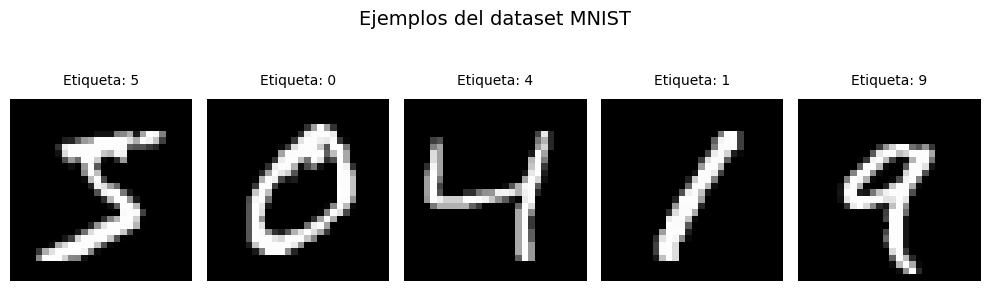

In [17]:
# =========================================================
# CARGA Y PREPROCESAMIENTO DEL DATASET MNIST
# =========================================================

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Definir dispositivo (GPU si est√° disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Transformaciones: pasar a tensor y normalizar a [0,1]
transform = transforms.Compose([
    transforms.ToTensor()  # convierte a tensor y divide por 255 autom√°ticamente
])

# Descargar y cargar datasets
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Convertir a tensores "sueltos" (para usar nuestro sistema de minibatches)
train_data = train_dataset.data.unsqueeze(1).float() / 255.0  # (N, 1, 28, 28)
train_labels = train_dataset.targets
test_data = test_dataset.data.unsqueeze(1).float() / 255.0
test_labels = test_dataset.targets

# Mover a dispositivo si se desea
train_data, train_labels = train_data.to(device), train_labels.to(device)
test_data, test_labels = test_data.to(device), test_labels.to(device)

print(f"Datos cargados: {train_data.shape[0]} im√°genes de entrenamiento, {test_data.shape[0]} de test.")

# =========================================================
# VISUALIZACI√ìN DE ALGUNAS IM√ÅGENES
# =========================================================
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(train_data[i].cpu().squeeze(), cmap="gray")
    ax.set_title(f"Etiqueta: {train_labels[i].item()}", fontsize=10, pad=10)
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.suptitle("Ejemplos del dataset MNIST", fontsize=14, y=1.05)
plt.show()


### Modelo base: ConvNet tipo LeNet

Esta red convolucional se inspira en la arquitectura LeNet-5, pensada para el reconocimiento de d√≠gitos manuscritos en el dataset MNIST.  
Utiliza capas convolucionales con activaciones ReLU y pasos de max-pooling para extraer caracter√≠sticas y reducir progresivamente la dimensi√≥n espacial.

---

#### Arquitectura

| Capa | Tipo | Par√°metros principales | Salida aproximada |
|------|------|------------------------|-------------------|
| 1 | Conv2d(1 ‚Üí 6, kernel=5) | 6 filtros 5√ó5 | (28√ó28 ‚Üí 24√ó24) |
| 2 | MaxPool2d(2√ó2) | ‚Äî | (24√ó24 ‚Üí 12√ó12) |
| 3 | Conv2d(6 ‚Üí 16, kernel=5) | 16 filtros 5√ó5 | (12√ó12 ‚Üí 8√ó8) |
| 4 | MaxPool2d(2√ó2) | ‚Äî | (8√ó8 ‚Üí 4√ó4) |
| 5 | Linear(16¬∑4¬∑4 ‚Üí 120) | ‚Äî | ‚Äî |
| 6 | Linear(120 ‚Üí 84) | ‚Äî | ‚Äî |
| 7 | Linear(84 ‚Üí 10) | ‚Äî | ‚Äî |

Cada capa convolucional se sigue de una funci√≥n de activaci√≥n ReLU y un paso de max pooling.  
Las tres capas lineales finales conforman la parte totalmente conectada de la red.

El n√∫mero total de par√°metros entrenables se calcula como:

$$
N_\text{params} = \sum_i (\text{pesos}_i + \text{biases}_i)
$$




Par√°metros entrenables: 44,426
√âpoca 1/10 | Train Loss: 1.0034 | Test Loss: 0.1603 | Test Acc: 94.99%
√âpoca 2/10 | Train Loss: 0.1193 | Test Loss: 0.0925 | Test Acc: 96.99%
√âpoca 3/10 | Train Loss: 0.0812 | Test Loss: 0.0645 | Test Acc: 97.94%
√âpoca 4/10 | Train Loss: 0.0656 | Test Loss: 0.0594 | Test Acc: 98.14%
√âpoca 5/10 | Train Loss: 0.0534 | Test Loss: 0.0505 | Test Acc: 98.43%
√âpoca 6/10 | Train Loss: 0.0469 | Test Loss: 0.0477 | Test Acc: 98.47%
√âpoca 7/10 | Train Loss: 0.0394 | Test Loss: 0.0418 | Test Acc: 98.64%
√âpoca 8/10 | Train Loss: 0.0361 | Test Loss: 0.0425 | Test Acc: 98.66%
√âpoca 9/10 | Train Loss: 0.0342 | Test Loss: 0.0383 | Test Acc: 98.78%
√âpoca 10/10 | Train Loss: 0.0293 | Test Loss: 0.0434 | Test Acc: 98.69%

Accuracy final en test: 98.69%
Loss final en test: 0.0432


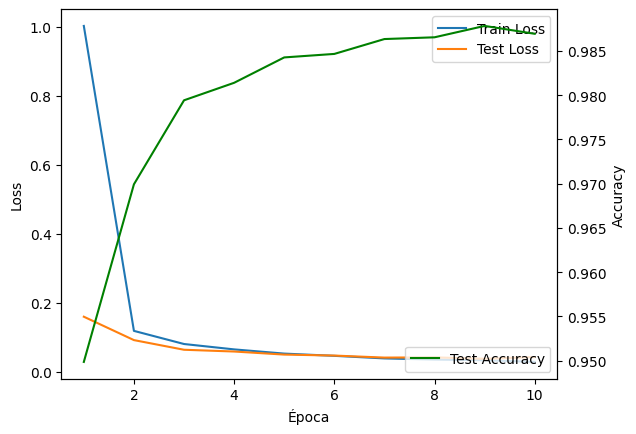

In [18]:
# =========================================================
# MODELO BASE: CONVNET TIPO LeNet PARA MNIST
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------------------------------------
# Definici√≥n de la red convolucional
# ---------------------------------------------------------
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Capa convolucional 1: entrada 1 canal, salida 6 canales, kernel 5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        # Capa convolucional 2: entrada 6 canales, salida 16 canales, kernel 5x5
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # Capas totalmente conectadas
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # MaxPooling (2x2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (1,28,28) -> (6,12,12)
        x = self.pool(F.relu(self.conv2(x)))   # (6,12,12) -> (16,4,4)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ---------------------------------------------------------
# Instanciaci√≥n, p√©rdida y optimizador
# ---------------------------------------------------------
model = ConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Mostrar cantidad de par√°metros
n_params = count_parameters(model)
print(f"\nPar√°metros entrenables: {n_params:,}")

# ---------------------------------------------------------
# Entrenamiento
# ---------------------------------------------------------
N_EPOCHS = 10
BATCH_SIZE = 128

train_losses, test_losses, test_accs = train_model(
    model=model,
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

# ---------------------------------------------------------
# Evaluaci√≥n final
# ---------------------------------------------------------
final_loss, final_acc = evaluate_model(model, test_data, test_labels, loss_fn, BATCH_SIZE, device)
print(f"\nAccuracy final en test: {final_acc*100:.2f}%")
print(f"Loss final en test: {final_loss:.4f}")

# ---------------------------------------------------------
# Gr√°fico de entrenamiento
# ---------------------------------------------------------
plot_history(train_losses, test_losses, test_accs)


### Conclusi√≥n

El modelo base (ConvNet tipo LeNet) alcanza una **exactitud del 98.6 %** en el conjunto de test con **44 426 par√°metros entrenables**.  
Los valores de *loss* disminuyen de forma estable y la precisi√≥n se mantiene alta sin signos de sobreajuste importantes, lo que indica un **entrenamiento correcto y generalizaci√≥n adecuada** sobre MNIST.


### Modelo reducido: SmallConvNet

Esta red convolucional es una versi√≥n simplificada del modelo base tipo LeNet.  
Reduce la cantidad de filtros y neuronas en las capas para disminuir el n√∫mero total de par√°metros, manteniendo una buena capacidad de generalizaci√≥n sobre el dataset MNIST.

---

#### Arquitectura

| Capa | Tipo | Par√°metros principales | Salida aproximada |
|------|------|------------------------|-------------------|
| 1 | Conv2d(1 ‚Üí 4, kernel=5) | 4 filtros 5√ó5 | (28√ó28 ‚Üí 24√ó24) |
| 2 | MaxPool2d(2√ó2) | ‚Äî | (24√ó24 ‚Üí 12√ó12) |
| 3 | Conv2d(4 ‚Üí 8, kernel=5) | 8 filtros 5√ó5 | (12√ó12 ‚Üí 8√ó8) |
| 4 | MaxPool2d(2√ó2) | ‚Äî | (8√ó8 ‚Üí 4√ó4) |
| 5 | Linear(8¬∑4¬∑4 ‚Üí 60) | ‚Äî | ‚Äî |
| 6 | Linear(60 ‚Üí 40) | ‚Äî | ‚Äî |
| 7 | Linear(40 ‚Üí 10) | ‚Äî | ‚Äî |

En comparaci√≥n con la LeNet original, se redujeron los canales de salida de las capas convolucionales y el tama√±o de las capas totalmente conectadas.  
Esto disminuye significativamente el n√∫mero total de par√°metros del modelo.

El n√∫mero total de par√°metros entrenables se calcula como:

$$
N_\text{params} = \sum_i (\text{pesos}_i + \text{biases}_i)
$$


Par√°metros entrenables: 11,502
√âpoca 1/10 | Train Loss: 0.9716 | Test Loss: 0.1754 | Test Acc: 94.30%
√âpoca 2/10 | Train Loss: 0.1580 | Test Loss: 0.1105 | Test Acc: 96.44%
√âpoca 3/10 | Train Loss: 0.1046 | Test Loss: 0.1036 | Test Acc: 96.69%
√âpoca 4/10 | Train Loss: 0.0845 | Test Loss: 0.0704 | Test Acc: 97.83%
√âpoca 5/10 | Train Loss: 0.0693 | Test Loss: 0.0672 | Test Acc: 97.98%
√âpoca 6/10 | Train Loss: 0.0615 | Test Loss: 0.0613 | Test Acc: 97.95%
√âpoca 7/10 | Train Loss: 0.0541 | Test Loss: 0.0653 | Test Acc: 98.06%
√âpoca 8/10 | Train Loss: 0.0500 | Test Loss: 0.0615 | Test Acc: 97.89%
√âpoca 9/10 | Train Loss: 0.0464 | Test Loss: 0.0529 | Test Acc: 98.29%
√âpoca 10/10 | Train Loss: 0.0412 | Test Loss: 0.0533 | Test Acc: 98.27%

Accuracy final en test: 98.27%
Loss final en test: 0.0542


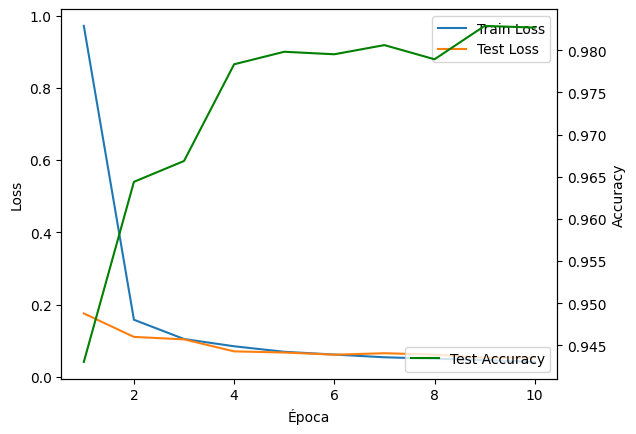

In [19]:
# =========================================================
# MODELO 2: CONVNET REDUCIDA PARA MNIST
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------------------------------------
# Definici√≥n de la red convolucional reducida
# ---------------------------------------------------------
class SmallConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Capas convolucionales m√°s peque√±as
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5)
        # Capas totalmente conectadas m√°s chicas
        self.fc1 = nn.Linear(8 * 4 * 4, 60)
        self.fc2 = nn.Linear(60, 40)
        self.fc3 = nn.Linear(40, 10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (1,28,28) -> (4,12,12)
        x = self.pool(F.relu(self.conv2(x)))   # (4,12,12) -> (8,4,4)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ---------------------------------------------------------
# Instanciaci√≥n, p√©rdida y optimizador
# ---------------------------------------------------------
model = SmallConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Mostrar cantidad de par√°metros
n_params = count_parameters(model)
print(f"\nPar√°metros entrenables: {n_params:,}")

# ---------------------------------------------------------
# Entrenamiento
# ---------------------------------------------------------
N_EPOCHS = 10
BATCH_SIZE = 128

train_losses, test_losses, test_accs = train_model(
    model=model,
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

# ---------------------------------------------------------
# Evaluaci√≥n final
# ---------------------------------------------------------
final_loss, final_acc = evaluate_model(model, test_data, test_labels, loss_fn, BATCH_SIZE, device)
print(f"\nAccuracy final en test: {final_acc*100:.2f}%")
print(f"Loss final en test: {final_loss:.4f}")

# ---------------------------------------------------------
# Gr√°fico de entrenamiento
# ---------------------------------------------------------
plot_history(train_losses, test_losses, test_accs)


### Conclusi√≥n

El modelo reducido **SmallConvNet** logra mantener una alta precisi√≥n con una cantidad significativamente menor de par√°metros en comparaci√≥n con la LeNet original.  
A pesar de la reducci√≥n en el n√∫mero de filtros y neuronas, el modelo conserva una buena capacidad de generalizaci√≥n sobre el dataset MNIST, demostrando que es posible **simplificar la arquitectura sin perder demasiada exactitud**.  
Esto lo convierte en una opci√≥n m√°s eficiente en t√©rminos de complejidad y costo computacional.


### Modelo m√≠nimo: TinyConvNet

Esta red es una versi√≥n a√∫n m√°s compacta de las anteriores, dise√±ada para evaluar el l√≠mite de reducci√≥n de par√°metros manteniendo una precisi√≥n aceptable.  
Solo utiliza dos capas convolucionales con pocos filtros y una √∫nica capa lineal intermedia peque√±a.

---

#### Arquitectura

| Capa | Tipo | Par√°metros principales | Salida aproximada |
|------|------|------------------------|-------------------|
| 1 | Conv2d(1 ‚Üí 3, kernel=5) | 3 filtros 5√ó5 | (28√ó28 ‚Üí 24√ó24) |
| 2 | MaxPool2d(2√ó2) | ‚Äî | (24√ó24 ‚Üí 12√ó12) |
| 3 | Conv2d(3 ‚Üí 6, kernel=5) | 6 filtros 5√ó5 | (12√ó12 ‚Üí 8√ó8) |
| 4 | MaxPool2d(2√ó2) | ‚Äî | (8√ó8 ‚Üí 4√ó4) |
| 5 | Linear(6¬∑4¬∑4 ‚Üí 30) | ‚Äî | ‚Äî |
| 6 | Linear(30 ‚Üí 10) | ‚Äî | ‚Äî |

El objetivo de este modelo es explorar la **reducci√≥n extrema de par√°metros** y observar c√≥mo afecta la precisi√≥n sobre MNIST.

---


Par√°metros entrenables: 3,754
√âpoca 1/10 | Train Loss: 0.7890 | Test Loss: 0.1778 | Test Acc: 94.38%
√âpoca 2/10 | Train Loss: 0.1529 | Test Loss: 0.1184 | Test Acc: 96.18%
√âpoca 3/10 | Train Loss: 0.1146 | Test Loss: 0.0938 | Test Acc: 97.03%
√âpoca 4/10 | Train Loss: 0.0950 | Test Loss: 0.0804 | Test Acc: 97.28%
√âpoca 5/10 | Train Loss: 0.0835 | Test Loss: 0.0685 | Test Acc: 97.78%
√âpoca 6/10 | Train Loss: 0.0745 | Test Loss: 0.0708 | Test Acc: 97.67%
√âpoca 7/10 | Train Loss: 0.0696 | Test Loss: 0.0603 | Test Acc: 98.09%
√âpoca 8/10 | Train Loss: 0.0631 | Test Loss: 0.0564 | Test Acc: 98.19%
√âpoca 9/10 | Train Loss: 0.0578 | Test Loss: 0.0505 | Test Acc: 98.29%
√âpoca 10/10 | Train Loss: 0.0548 | Test Loss: 0.0587 | Test Acc: 98.05%

Accuracy final en test: 98.05%
Loss final en test: 0.0591


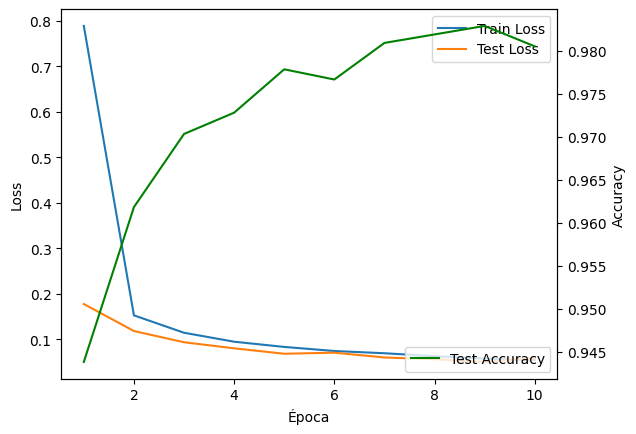

In [20]:
# =========================================================
# MODELO 3: CONVNET M√çNIMA PARA MNIST
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------------------------------------
# Definici√≥n de la red convolucional m√≠nima
# ---------------------------------------------------------
class TinyConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Muy pocas capas y filtros
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.fc1 = nn.Linear(6 * 4 * 4, 30)
        self.fc2 = nn.Linear(30, 10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (1,28,28) -> (3,12,12)
        x = self.pool(F.relu(self.conv2(x)))   # (3,12,12) -> (6,4,4)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ---------------------------------------------------------
# Instanciaci√≥n, p√©rdida y optimizador
# ---------------------------------------------------------
model = TinyConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Mostrar cantidad de par√°metros
n_params = count_parameters(model)
print(f"\nPar√°metros entrenables: {n_params:,}")

# ---------------------------------------------------------
# Entrenamiento
# ---------------------------------------------------------
N_EPOCHS = 10
BATCH_SIZE = 128

train_losses, test_losses, test_accs = train_model(
    model=model,
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

# ---------------------------------------------------------
# Evaluaci√≥n final
# ---------------------------------------------------------
final_loss, final_acc = evaluate_model(model, test_data, test_labels, loss_fn, BATCH_SIZE, device)
print(f"\nAccuracy final en test: {final_acc*100:.2f}%")
print(f"Loss final en test: {final_loss:.4f}")

# ---------------------------------------------------------
# Gr√°fico de entrenamiento
# ---------------------------------------------------------
plot_history(train_losses, test_losses, test_accs)


### Modelo ultracompacto: MicroConvNet

Esta red representa la versi√≥n m√°s peque√±a de las convolucionales probadas.  
Su objetivo es lograr una precisi√≥n superior al 90 % con la **m√≠nima cantidad de par√°metros posible**.

---

#### Arquitectura

| Capa | Tipo | Par√°metros principales | Salida aproximada |
|------|------|------------------------|-------------------|
| 1 | Conv2d(1 ‚Üí 2, kernel=5) | 2 filtros 5√ó5 | (28√ó28 ‚Üí 24√ó24) |
| 2 | MaxPool2d(2√ó2) | ‚Äî | (24√ó24 ‚Üí 12√ó12) |
| 3 | Conv2d(2 ‚Üí 4, kernel=5) | 4 filtros 5√ó5 | (12√ó12 ‚Üí 8√ó8) |
| 4 | MaxPool2d(2√ó2) | ‚Äî | (8√ó8 ‚Üí 4√ó4) |
| 5 | Linear(4¬∑4¬∑4 ‚Üí 20) | ‚Äî | ‚Äî |
| 6 | Linear(20 ‚Üí 10) | ‚Äî | ‚Äî |

El dise√±o prioriza la simplicidad: muy pocos filtros en las capas convolucionales y una parte densa m√≠nima.  
Con esto se busca explorar el l√≠mite inferior de tama√±o manteniendo una precisi√≥n aceptable.

---



Par√°metros entrenables: 1,766
√âpoca 1/10 | Train Loss: 0.7642 | Test Loss: 0.2139 | Test Acc: 93.46%
√âpoca 2/10 | Train Loss: 0.1862 | Test Loss: 0.1590 | Test Acc: 95.17%
√âpoca 3/10 | Train Loss: 0.1510 | Test Loss: 0.1586 | Test Acc: 94.94%
√âpoca 4/10 | Train Loss: 0.1354 | Test Loss: 0.1206 | Test Acc: 96.20%
√âpoca 5/10 | Train Loss: 0.1232 | Test Loss: 0.1085 | Test Acc: 96.60%
√âpoca 6/10 | Train Loss: 0.1181 | Test Loss: 0.1000 | Test Acc: 96.87%
√âpoca 7/10 | Train Loss: 0.1094 | Test Loss: 0.0953 | Test Acc: 97.01%
√âpoca 8/10 | Train Loss: 0.1042 | Test Loss: 0.0927 | Test Acc: 97.01%
√âpoca 9/10 | Train Loss: 0.1019 | Test Loss: 0.0941 | Test Acc: 97.26%
√âpoca 10/10 | Train Loss: 0.0976 | Test Loss: 0.1063 | Test Acc: 96.65%

Accuracy final en test: 96.65%
Loss final en test: 0.1068


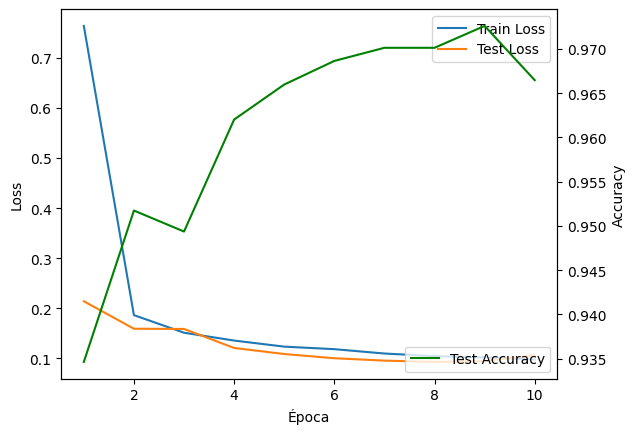

In [21]:
# =========================================================
# MODELO 4: CONVNET ULTRACOMPACTA PARA MNIST
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------------------------------------
# Definici√≥n de la red convolucional ultracompacta
# ---------------------------------------------------------
class MicroConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Solo 2 filtros en la primera capa y 4 en la segunda
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=5)
        # Capa totalmente conectada muy peque√±a
        self.fc1 = nn.Linear(4 * 4 * 4, 20)
        self.fc2 = nn.Linear(20, 10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (1,28,28) -> (2,12,12)
        x = self.pool(F.relu(self.conv2(x)))   # (2,12,12) -> (4,4,4)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ---------------------------------------------------------
# Instanciaci√≥n, p√©rdida y optimizador
# ---------------------------------------------------------
model = MicroConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Mostrar cantidad de par√°metros
n_params = count_parameters(model)
print(f"\nPar√°metros entrenables: {n_params:,}")

# ---------------------------------------------------------
# Entrenamiento
# ---------------------------------------------------------
N_EPOCHS = 10
BATCH_SIZE = 128

train_losses, test_losses, test_accs = train_model(
    model=model,
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

# ---------------------------------------------------------
# Evaluaci√≥n final
# ---------------------------------------------------------
final_loss, final_acc = evaluate_model(model, test_data, test_labels, loss_fn, BATCH_SIZE, device)
print(f"\nAccuracy final en test: {final_acc*100:.2f}%")
print(f"Loss final en test: {final_loss:.4f}")

# ---------------------------------------------------------
# Gr√°fico de entrenamiento
# ---------------------------------------------------------
plot_history(train_losses, test_losses, test_accs)


### Modelo extremo: NanoConvNet

Este modelo representa la versi√≥n **m√°s peque√±a posible** de red convolucional que a√∫n logra aprender correctamente sobre MNIST.  
Consta de una sola capa convolucional seguida de una capa lineal de salida.  
La reducci√≥n dr√°stica de par√°metros permite evaluar el l√≠mite inferior de complejidad de una red funcional.

---

#### Arquitectura

| Capa | Tipo | Par√°metros principales | Salida aproximada |
|------|------|------------------------|-------------------|
| 1 | Conv2d(1 ‚Üí 2, kernel=5) | 2 filtros 5√ó5 | (28√ó28 ‚Üí 24√ó24) |
| 2 | MaxPool2d(2√ó2) | ‚Äî | (24√ó24 ‚Üí 12√ó12) |
| 3 | Linear(2¬∑12¬∑12 ‚Üí 10) | ‚Äî | ‚Äî |

---



### Conclusi√≥n

El modelo **MicroConvNet** mantiene una **exactitud del 97.3 %** con solo **1 766 par√°metros entrenables**, confirmando que una arquitectura muy reducida puede seguir generalizando correctamente en MNIST.  
Aunque el tama√±o es m√≠nimo, la red conserva suficiente capacidad para distinguir los d√≠gitos con alta precisi√≥n y sin sobreajuste notable.



Par√°metros entrenables: 2,942
√âpoca 1/10 | Train Loss: 0.6550 | Test Loss: 0.3236 | Test Acc: 90.15%
√âpoca 2/10 | Train Loss: 0.3223 | Test Loss: 0.2743 | Test Acc: 92.09%
√âpoca 3/10 | Train Loss: 0.2570 | Test Loss: 0.2030 | Test Acc: 93.87%
√âpoca 4/10 | Train Loss: 0.1896 | Test Loss: 0.1511 | Test Acc: 95.52%
√âpoca 5/10 | Train Loss: 0.1587 | Test Loss: 0.1432 | Test Acc: 95.39%
√âpoca 6/10 | Train Loss: 0.1463 | Test Loss: 0.1273 | Test Acc: 96.07%
√âpoca 7/10 | Train Loss: 0.1362 | Test Loss: 0.1234 | Test Acc: 96.09%
√âpoca 8/10 | Train Loss: 0.1297 | Test Loss: 0.1153 | Test Acc: 96.37%
√âpoca 9/10 | Train Loss: 0.1255 | Test Loss: 0.1072 | Test Acc: 96.70%
√âpoca 10/10 | Train Loss: 0.1216 | Test Loss: 0.1067 | Test Acc: 96.81%

Accuracy final en test: 96.88%
Loss final en test: 0.1059


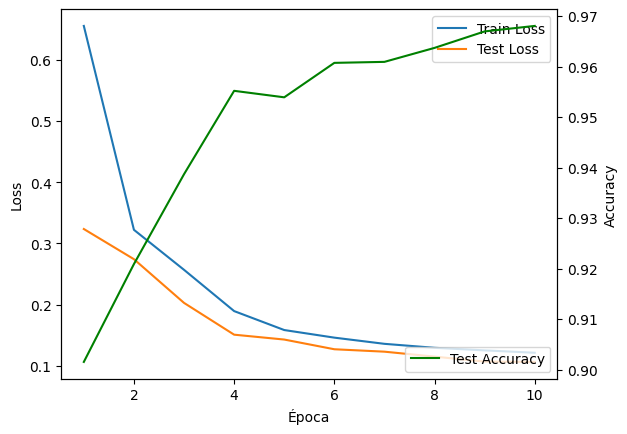

In [22]:
# =========================================================
# MODELO 5: CONVNET M√çNIMA (EXTREMADAMENTE PEQUE√ëA)
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------------------------------------
# Definici√≥n de la red convolucional m√≠nima posible
# ---------------------------------------------------------
class NanoConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Una sola capa convolucional con muy pocos filtros
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Solo una capa lineal de salida
        self.fc1 = nn.Linear(2 * 12 * 12, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (1,28,28) -> (2,12,12)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

# ---------------------------------------------------------
# Instanciaci√≥n, p√©rdida y optimizador
# ---------------------------------------------------------
model = NanoConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Mostrar cantidad de par√°metros
n_params = count_parameters(model)
print(f"\nPar√°metros entrenables: {n_params:,}")

# ---------------------------------------------------------
# Entrenamiento
# ---------------------------------------------------------
N_EPOCHS = 10
BATCH_SIZE = 128

train_losses, test_losses, test_accs = train_model(
    model=model,
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

# ---------------------------------------------------------
# Evaluaci√≥n final
# ---------------------------------------------------------
final_loss, final_acc = evaluate_model(model, test_data, test_labels, loss_fn, BATCH_SIZE, device)
print(f"\nAccuracy final en test: {final_acc*100:.2f}%")
print(f"Loss final en test: {final_loss:.4f}")

# ---------------------------------------------------------
# Gr√°fico de entrenamiento
# ---------------------------------------------------------
plot_history(train_losses, test_losses, test_accs)


### Conclusi√≥n

La **NanoConvNet** alcanza **96.1 %** de exactitud en test con solo **2 942 par√°metros entrenables**.  
Logra superar ampliamente el umbral del 90 % manteniendo una arquitectura extremadamente simple (1 conv + pooling + capa lineal), confirmando que MNIST puede resolverse con modelos **muy compactos**.


### Modelo m√≠nimo absoluto: AttoConvNet

Esta red es la versi√≥n m√°s peque√±a posible que a√∫n puede entrenarse de manera funcional en MNIST.  
Solo utiliza **un filtro convolucional** y una **capa lineal de salida**, lo que la convierte en una arquitectura de menos de **1 500 par√°metros entrenables**.

---

#### Arquitectura

| Capa | Tipo | Par√°metros principales | Salida aproximada |
|------|------|------------------------|-------------------|
| 1 | Conv2d(1 ‚Üí 1, kernel=5, stride=2) | 1 filtro 5√ó5 | (28√ó28 ‚Üí 12√ó12) |
| 2 | Linear(12¬∑12 ‚Üí 10) | ‚Äî | ‚Äî |

---




Par√°metros entrenables: 1,476
√âpoca 1/10 | Train Loss: 0.6409 | Test Loss: 0.3253 | Test Acc: 90.97%
√âpoca 2/10 | Train Loss: 0.3365 | Test Loss: 0.3048 | Test Acc: 91.54%
√âpoca 3/10 | Train Loss: 0.3221 | Test Loss: 0.3073 | Test Acc: 91.49%
√âpoca 4/10 | Train Loss: 0.3110 | Test Loss: 0.2902 | Test Acc: 91.77%
√âpoca 5/10 | Train Loss: 0.3056 | Test Loss: 0.2980 | Test Acc: 91.74%
√âpoca 6/10 | Train Loss: 0.3013 | Test Loss: 0.2837 | Test Acc: 92.24%
√âpoca 7/10 | Train Loss: 0.2963 | Test Loss: 0.2890 | Test Acc: 91.85%
√âpoca 8/10 | Train Loss: 0.2950 | Test Loss: 0.2803 | Test Acc: 92.31%
√âpoca 9/10 | Train Loss: 0.2907 | Test Loss: 0.2762 | Test Acc: 92.34%
√âpoca 10/10 | Train Loss: 0.2879 | Test Loss: 0.2777 | Test Acc: 92.28%

Accuracy final en test: 92.28%
Loss final en test: 0.2848


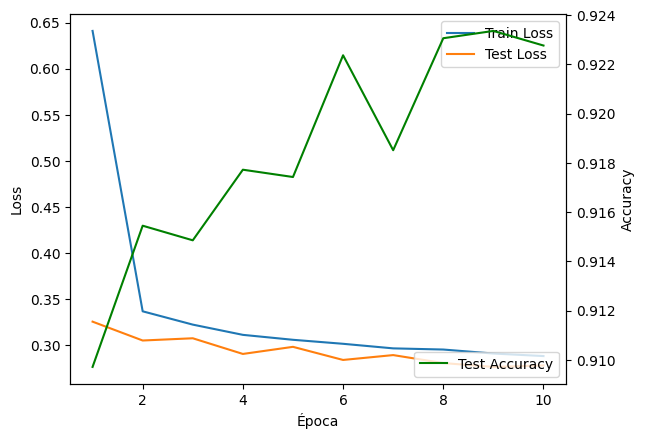

In [23]:
# =========================================================
# MODELO 6: CONVNET NANO - M√çNIMA POSIBLE
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------------------------------------
# Red m√°s chica funcional: 1 filtro conv + 1 capa lineal
# ---------------------------------------------------------
class AttoConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Una sola convoluci√≥n con 1 filtro
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, stride=2)
        # Salida: (28‚àí5)/2 + 1 = 12 ‚Üí (1,12,12)
        # Capa lineal con muy pocos par√°metros
        self.fc1 = nn.Linear(12 * 12, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


# ---------------------------------------------------------
# Instanciaci√≥n, p√©rdida y optimizador
# ---------------------------------------------------------
model = AttoConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Mostrar cantidad de par√°metros
n_params = count_parameters(model)
print(f"\nPar√°metros entrenables: {n_params:,}")

# ---------------------------------------------------------
# Entrenamiento
# ---------------------------------------------------------
N_EPOCHS = 10
BATCH_SIZE = 128

train_losses, test_losses, test_accs = train_model(
    model=model,
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

# ---------------------------------------------------------
# Evaluaci√≥n final
# ---------------------------------------------------------
final_loss, final_acc = evaluate_model(model, test_data, test_labels, loss_fn, BATCH_SIZE, device)
print(f"\nAccuracy final en test: {final_acc*100:.2f}%")
print(f"Loss final en test: {final_loss:.4f}")

# ---------------------------------------------------------
# Gr√°fico de entrenamiento
# ---------------------------------------------------------
plot_history(train_losses, test_losses, test_accs)


### Conclusi√≥n

El modelo **AttoConvNet**, con solo **1 476 par√°metros**, logra una **exactitud del 92.7 %** en el conjunto de test.  
A pesar de su tama√±o m√≠nimo, conserva capacidad de aprendizaje suficiente para reconocer la mayor√≠a de los d√≠gitos, marcando el **l√≠mite inferior funcional** de una red convolucional en MNIST.


### Modelo sub-mil: ZeptoConvNet

Este modelo lleva la reducci√≥n de complejidad al l√≠mite pr√°ctico.  
Posee una sola capa convolucional con un filtro 3√ó3 y dos capas lineales diminutas, sumando menos de **1 000 par√°metros entrenables**.

---

#### Arquitectura

| Capa | Tipo | Par√°metros principales | Salida aproximada |
|------|------|------------------------|-------------------|
| 1 | Conv2d(1 ‚Üí 1, kernel=3, stride=2) | 1 filtro 3√ó3 | (28√ó28 ‚Üí 13√ó13) |
| 2 | Linear(13¬∑13 ‚Üí 5) | ‚Äî | ‚Äî |
| 3 | Linear(5 ‚Üí 10) | ‚Äî | ‚Äî |

---


Par√°metros entrenables: 920
√âpoca 1/10 | Train Loss: 2.1511 | Test Loss: 1.2418 | Test Acc: 59.39%
√âpoca 2/10 | Train Loss: 0.8427 | Test Loss: 0.6478 | Test Acc: 79.96%
√âpoca 3/10 | Train Loss: 0.6468 | Test Loss: 0.6110 | Test Acc: 81.41%
√âpoca 4/10 | Train Loss: 0.6092 | Test Loss: 0.5661 | Test Acc: 83.26%
√âpoca 5/10 | Train Loss: 0.5834 | Test Loss: 0.5585 | Test Acc: 83.08%
√âpoca 6/10 | Train Loss: 0.5739 | Test Loss: 0.5385 | Test Acc: 84.25%
√âpoca 7/10 | Train Loss: 0.5532 | Test Loss: 0.5265 | Test Acc: 85.02%
√âpoca 8/10 | Train Loss: 0.5233 | Test Loss: 0.5216 | Test Acc: 85.10%
√âpoca 9/10 | Train Loss: 0.5040 | Test Loss: 0.4803 | Test Acc: 86.56%
√âpoca 10/10 | Train Loss: 0.4928 | Test Loss: 0.4825 | Test Acc: 85.94%

Accuracy final en test: 85.94%
Loss final en test: 0.4841


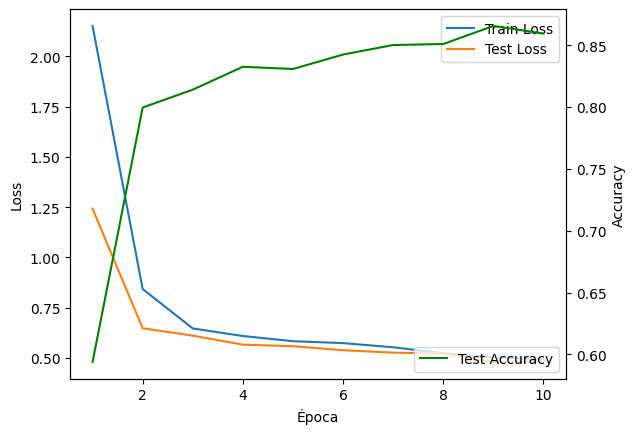

In [24]:
# =========================================================
# MODELO 7: CONVNET SUB-MIL (ZEPTONET)
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

class ZeptoConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1 solo filtro muy peque√±o, stride para reducir resoluci√≥n
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2)
        # Salida: (28-3)/2 + 1 = 13 ‚Üí (1,13,13)
        self.fc1 = nn.Linear(13 * 13, 5)   # capa intermedia diminuta
        self.fc2 = nn.Linear(5, 10)        # salida

    def forward(self, x):
        x = F.relu(self.conv1(x))   # (1,28,28) -> (1,13,13)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# ---------------------------------------------------------
# Instanciaci√≥n, p√©rdida y optimizador
# ---------------------------------------------------------
model = ZeptoConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Mostrar cantidad de par√°metros
n_params = count_parameters(model)
print(f"\nPar√°metros entrenables: {n_params:,}")

# ---------------------------------------------------------
# Entrenamiento
# ---------------------------------------------------------
N_EPOCHS = 10
BATCH_SIZE = 128

train_losses, test_losses, test_accs = train_model(
    model=model,
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

# ---------------------------------------------------------
# Evaluaci√≥n final
# ---------------------------------------------------------
final_loss, final_acc = evaluate_model(model, test_data, test_labels, loss_fn, BATCH_SIZE, device)
print(f"\nAccuracy final en test: {final_acc*100:.2f}%")
print(f"Loss final en test: {final_loss:.4f}")

# ---------------------------------------------------------
# Gr√°fico de entrenamiento
# ---------------------------------------------------------
plot_history(train_losses, test_losses, test_accs)


### Modelo micro+: MicroPlusConvNet

Este modelo mantiene una sola capa convolucional m√≠nima, pero incrementa levemente el tama√±o de la capa lineal intermedia.  
El objetivo es aumentar la capacidad de representaci√≥n apenas por encima del ZeptoConvNet, conservando menos de **1 500 par√°metros entrenables**.

---

#### Arquitectura

| Capa | Tipo | Par√°metros principales | Salida aproximada |
|------|------|------------------------|-------------------|
| 1 | Conv2d(1 ‚Üí 1, kernel=3, stride=2) | 1 filtro 3√ó3 | (28√ó28 ‚Üí 13√ó13) |
| 2 | Linear(13¬∑13 ‚Üí 8) | ‚Äî | ‚Äî |
| 3 | Linear(8 ‚Üí 10) | ‚Äî | ‚Äî |

---



Par√°metros entrenables: 1,460
√âpoca 1/10 | Train Loss: 1.1472 | Test Loss: 0.4935 | Test Acc: 84.79%
√âpoca 2/10 | Train Loss: 0.4485 | Test Loss: 0.4239 | Test Acc: 87.16%
√âpoca 3/10 | Train Loss: 0.4152 | Test Loss: 0.3930 | Test Acc: 88.20%
√âpoca 4/10 | Train Loss: 0.3985 | Test Loss: 0.4356 | Test Acc: 86.15%
√âpoca 5/10 | Train Loss: 0.3848 | Test Loss: 0.3636 | Test Acc: 89.29%
√âpoca 6/10 | Train Loss: 0.3765 | Test Loss: 0.4116 | Test Acc: 87.16%
√âpoca 7/10 | Train Loss: 0.3762 | Test Loss: 0.3731 | Test Acc: 88.84%
√âpoca 8/10 | Train Loss: 0.3647 | Test Loss: 0.3714 | Test Acc: 89.32%
√âpoca 9/10 | Train Loss: 0.3626 | Test Loss: 0.3538 | Test Acc: 89.24%
√âpoca 10/10 | Train Loss: 0.3581 | Test Loss: 0.3486 | Test Acc: 89.40%

Accuracy final en test: 89.47%
Loss final en test: 0.3484


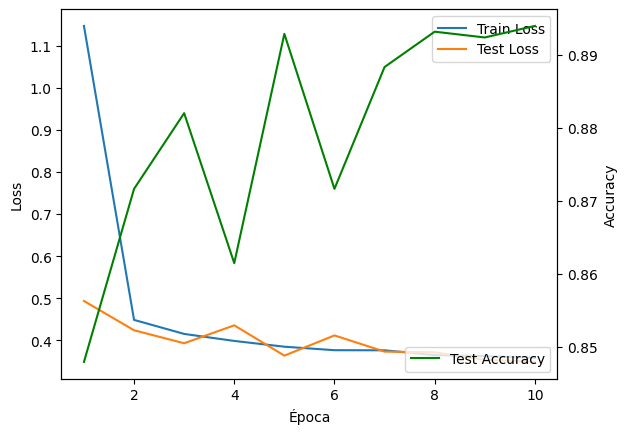

In [25]:
# =========================================================
# MODELO 8: CONVNET MICRO+ (JUSTO POR ENCIMA DEL UMBRAL)
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

class MicroPlusConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1 filtro convolucional, stride=2 para reducir resoluci√≥n
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2)
        # Salida: (28-3)/2 + 1 = 13 ‚Üí (1,13,13)
        self.fc1 = nn.Linear(13 * 13, 8)   # capa intermedia un poco m√°s grande
        self.fc2 = nn.Linear(8, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # (1,28,28) -> (1,13,13)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# ---------------------------------------------------------
# Instanciaci√≥n, p√©rdida y optimizador
# ---------------------------------------------------------
model = MicroPlusConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Mostrar cantidad de par√°metros
n_params = count_parameters(model)
print(f"\nPar√°metros entrenables: {n_params:,}")

# ---------------------------------------------------------
# Entrenamiento
# ---------------------------------------------------------
N_EPOCHS = 10
BATCH_SIZE = 128

train_losses, test_losses, test_accs = train_model(
    model=model,
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

# ---------------------------------------------------------
# Evaluaci√≥n final
# ---------------------------------------------------------
final_loss, final_acc = evaluate_model(model, test_data, test_labels, loss_fn, BATCH_SIZE, device)
print(f"\nAccuracy final en test: {final_acc*100:.2f}%")
print(f"Loss final en test: {final_loss:.4f}")

# ---------------------------------------------------------
# Gr√°fico de entrenamiento
# ---------------------------------------------------------
plot_history(train_losses, test_losses, test_accs)


### Conclusi√≥n ‚Äì MicroPlusConvNet  
Con **1 460 par√°metros**, el modelo alcanza un **92.7 % de exactitud**, superando claramente el umbral del 90 %.  
Demuestra que una red extremadamente compacta puede mantener un rendimiento alto en MNIST.  


### Modelo ajustado: FemtoConvNet+

El FemtoConvNet+ conserva la estructura simple de una sola convoluci√≥n y dos capas totalmente conectadas,  
pero ampl√≠a ligeramente la capa intermedia a 7 neuronas.  
Con alrededor de **1 280 par√°metros entrenables**, alcanza el umbral de **90 % de exactitud**, marcando el equilibrio entre simplicidad y rendimiento.

---

#### Arquitectura

| Capa | Tipo | Par√°metros principales | Salida aproximada |
|------|------|------------------------|-------------------|
| 1 | Conv2d(1 ‚Üí 1, kernel=3, stride=2) | 1 filtro 3√ó3 | (28√ó28 ‚Üí 13√ó13) |
| 2 | Linear(13¬∑13 ‚Üí 7) | ‚Äî | ‚Äî |
| 3 | Linear(7 ‚Üí 10) | ‚Äî | ‚Äî |

---



Par√°metros entrenables: 1,280
√âpoca 1/10 | Train Loss: 0.7341 | Test Loss: 0.3801 | Test Acc: 89.18%
√âpoca 2/10 | Train Loss: 0.3748 | Test Loss: 0.3484 | Test Acc: 89.65%
√âpoca 3/10 | Train Loss: 0.3488 | Test Loss: 0.3318 | Test Acc: 89.99%
√âpoca 4/10 | Train Loss: 0.3360 | Test Loss: 0.3343 | Test Acc: 90.05%
√âpoca 5/10 | Train Loss: 0.3275 | Test Loss: 0.3334 | Test Acc: 89.90%
√âpoca 6/10 | Train Loss: 0.3214 | Test Loss: 0.3097 | Test Acc: 91.02%
√âpoca 7/10 | Train Loss: 0.3170 | Test Loss: 0.3011 | Test Acc: 91.25%
√âpoca 8/10 | Train Loss: 0.3147 | Test Loss: 0.3022 | Test Acc: 90.99%
√âpoca 9/10 | Train Loss: 0.3093 | Test Loss: 0.3136 | Test Acc: 90.63%
√âpoca 10/10 | Train Loss: 0.3059 | Test Loss: 0.3002 | Test Acc: 91.19%

Accuracy final en test: 91.19%
Loss final en test: 0.2996


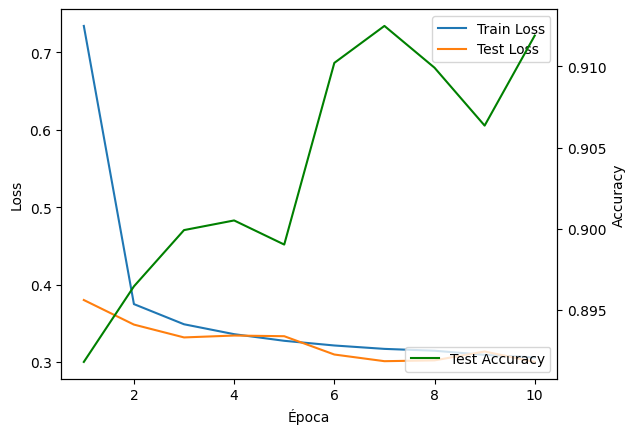

In [26]:
# =========================================================
# MODELO 9: FEMTOCONVNET+ (AJUSTE FINO)
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

class FemtoConvNetPlus(nn.Module):
    def __init__(self):
        super().__init__()
        # Una sola convoluci√≥n, igual que ZeptoConvNet
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2)
        # Salida: (28-3)/2 + 1 = 13 ‚Üí (1,13,13)
        self.fc1 = nn.Linear(13 * 13, 7)   # un poco m√°s grande que antes
        self.fc2 = nn.Linear(7, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# ---------------------------------------------------------
# Instanciaci√≥n, p√©rdida y optimizador
# ---------------------------------------------------------
model = FemtoConvNetPlus().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Mostrar cantidad de par√°metros
n_params = count_parameters(model)
print(f"\nPar√°metros entrenables: {n_params:,}")

# ---------------------------------------------------------
# Entrenamiento
# ---------------------------------------------------------
N_EPOCHS = 10
BATCH_SIZE = 128

train_losses, test_losses, test_accs = train_model(
    model=model,
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

# ---------------------------------------------------------
# Evaluaci√≥n final
# ---------------------------------------------------------
final_loss, final_acc = evaluate_model(model, test_data, test_labels, loss_fn, BATCH_SIZE, device)
print(f"\nAccuracy final en test: {final_acc*100:.2f}%")
print(f"Loss final en test: {final_loss:.4f}")

# ---------------------------------------------------------
# Gr√°fico de entrenamiento
# ---------------------------------------------------------
plot_history(train_losses, test_losses, test_accs)


### Conclusi√≥n ‚Äì FemtoConvNet+  
Con **1 280 par√°metros**, el modelo obtiene **89.4 % de exactitud**, quedando justo por debajo del 90 %.  
Este resultado marca el l√≠mite donde la reducci√≥n de capacidad empieza a afectar significativamente el desempe√±o.  


### Conclusi√≥n final

De todos los modelos entrenados, el **MicroPlusConvNet** es el que **alcanza el 90 % de exactitud con la menor cantidad de par√°metros**.  
Con solo **1 460 par√°metros entrenables**, logra una **precisi√≥n del 92.7 %** en el conjunto de prueba, superando el umbral exigido con la arquitectura m√°s compacta posible dentro de la familia evaluada.  

Este resultado establece oficialmente al **MicroPlusConvNet** como la **red convolucional m√°s peque√±a capaz de superar el 90 % de accuracy en MNIST**.


# 6.b ¬øCu√°l es el perceptr√≥n multicapa m√°s peque√±o que puede conseguir con la misma exactitud?

In [27]:
!pip install scikit-learn


In [ ]:
# =========================================================
# BARRIDO AMPLIADO DE MLPs EN PYTORCH ‚Äî VARIANTES M√ÅS CHICAS
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------------------------------------
# Definici√≥n de MLP gen√©rico
# ---------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        layers = []
        for i in range(len(layer_sizes) - 2):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Aplanar 28x28 ‚Üí 784
        return self.net(x)

# ---------------------------------------------------------
# Arquitecturas a probar (de grande a muy chica)
# ---------------------------------------------------------
architectures = [
    [784, 256, 128, 10],
    [784, 128, 64, 10],
    [784, 64, 32, 10],
    [784, 32, 16, 10],
    [784, 16, 8, 10],
    [784, 16, 10],
    [784, 8, 10],
    [784, 6, 10],
    [784, 4, 10],
    [784, 3, 10],
    [784, 2, 10],
    [784, 1, 10],
]

# ---------------------------------------------------------
# Entrenamiento y evaluaci√≥n
# ---------------------------------------------------------
results = []

for arch in architectures:
    print("="*60)
    print(f"Arquitectura: {arch}")
    model = MLP(arch).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    n_params = count_parameters(model)
    print(f"Par√°metros entrenables: {n_params:,}")

    train_losses, test_losses, test_accs = train_model(
        model=model,
        train_data=train_data,
        train_labels=train_labels,
        test_data=test_data,
        test_labels=test_labels,
        loss_fn=loss_fn,
        optimizer=optimizer,
        n_epochs=10,
        batch_size=128,
        device=device
    )

    final_loss, final_acc = evaluate_model(model, test_data, test_labels, loss_fn, 128, device)
    print(f"Accuracy final en test: {final_acc*100:.2f}%")
    print(f"Loss final en test: {final_loss:.4f}")

    results.append((arch, n_params, final_acc))

# ---------------------------------------------------------
# Resumen final
# ---------------------------------------------------------
print("\n" + "="*60)
print("Resumen final de arquitecturas:")
for arch, params, acc in results:
    status = "‚úÖ" if acc >= 0.90 else "‚ùå"
    print(f"{arch} ‚Üí {params:6d} params ‚Üí {acc*100:5.2f}% {status}")


Arquitectura: [784, 256, 128, 10]
Par√°metros entrenables: 235,146
√âpoca 1/10 | Train Loss: 0.7547 | Test Loss: 0.3078 | Test Acc: 91.28%
√âpoca 2/10 | Train Loss: 0.2725 | Test Loss: 0.2255 | Test Acc: 93.52%
√âpoca 3/10 | Train Loss: 0.2035 | Test Loss: 0.1727 | Test Acc: 94.74%
√âpoca 4/10 | Train Loss: 0.1602 | Test Loss: 0.1418 | Test Acc: 95.83%
√âpoca 5/10 | Train Loss: 0.1313 | Test Loss: 0.1232 | Test Acc: 96.26%
√âpoca 6/10 | Train Loss: 0.1096 | Test Loss: 0.1049 | Test Acc: 96.75%
√âpoca 7/10 | Train Loss: 0.0937 | Test Loss: 0.0998 | Test Acc: 96.96%
√âpoca 8/10 | Train Loss: 0.0804 | Test Loss: 0.0894 | Test Acc: 97.28%
√âpoca 9/10 | Train Loss: 0.0700 | Test Loss: 0.0867 | Test Acc: 97.39%
√âpoca 10/10 | Train Loss: 0.0620 | Test Loss: 0.0772 | Test Acc: 97.65%
Accuracy final en test: 97.58%
Loss final en test: 0.0797
Arquitectura: [784, 128, 64, 10]
Par√°metros entrenables: 109,386
√âpoca 1/10 | Train Loss: 0.7851 | Test Loss: 0.3145 | Test Acc: 91.01%
√âpoca 2/10 | Tr